In [1]:
dataset = "Alithea_Lyon_normalised_deseq.csv"
timepoints = [24]
treatments_of_interest = [
    "BCS-AA31476",
    "BCS-AF75363",
    "BCS-AH28139",
    "BCS-AI38388",
    "BCS-AJ10138",
    "BCS-AR83685",
    "BCS-BY16023",
    "BCS-CN88460",
    "BCS-CY24726",
]
treatments_of_interest = sorted(list(set(treatments_of_interest)))

# Numbers for Sven
1. Average size of gene per cut-off
2. Means and Std of the Mahanolbis distance from the stripplot
3. Variance or std of DMSOs
4. How many sidgnificantly DEG in every treatment


# To-do paper
Fill in numbers
- Average response in M distance for multiRNAseq vs RNAseq responses + standard deviation
- Average response + standard deviation for DMSO control
- How many genes are significantly regulated
1. Add Methods section
2. Proof-read
3. Change figures
Figure
1a) decay of genes covered by thresholds 1,5,10,50,100,500,1000
1b) Overlap 1, 10, 100, 1000? moonphases
1c) panel B and C
1d) D
2 ) as is but order Respiration (Isoflucypram), Sterol Biosyntheis (Tebuconazole), Cytoskeleton (Diethofencarb), Multisite (M1)
3) What about UMAP and hierarchical map?
 

In [2]:
import os

import numpy as np
import pandas as pd

os.chdir("/home/ec2-user/sophia_comparison")
os.system(". /home/ec2-user/sophia_comparison/s3fs.sh")

mkdir: cannot create directory ‘s3_mount’: File exists
s3fs: MOUNTPOINT directory ./s3_mount is not empty. if you are sure this is safe, can use the 'nonempty' mount option.


256

In [3]:
def process_dataset(dataset, timepoints):
    df = pd.read_csv(dataset, index_col=0)
    df["Metadata_Treatments_and_timepoints"] = (
        df["Metadata_treatments"] + " at " + df["Metadata_Timepoints"].astype(str) + "h"
    )
    df = df[df["Metadata_Timepoints"].isin(timepoints)]
    type_rna = "alithea_batch"

    # df.rename(columns = gene_map, inplace=True)
    # df.columns = [f"{col}_{i}" if df.columns.tolist()[:idx].count(col) else col for idx, (col, i) in enumerate(zip(df.columns, range(len(df.columns))))]
    cpd_df = pd.read_csv("moa_clustering4paper.csv")

    cpd_df.columns = [
        "Metadata_" + x.replace("/ ", "").replace(" ", "_") for x in cpd_df.columns
    ]
    cpd_df["Metadata_Mode_of_Action"] = [
        x.capitalize() for x in cpd_df["Metadata_Mode_of_Action"].fillna("Unavailable")
    ]
    cpd_df["Metadata_Name_Chemical_group"] = [
        x.capitalize() for x in cpd_df["Metadata_Name_Chemical_group"]
    ]
    clear_name_map = dict(
        zip(cpd_df["Metadata_BCS-code"], cpd_df["Metadata_Name_Chemical_group"])
    )

    df = df.merge(
        cpd_df, left_on="Metadata_treatments", right_on="Metadata_BCS-code", how="left"
    )
    df.reset_index(drop=True, inplace=True)
    df.loc[df["Metadata_treatments"] == "DMSO", "Metadata_Name_Chemical_group"] = "DMSO"

    df["Metadata_Name_Chemical_group"].fillna("", inplace=True)
    df.loc[df["Metadata_treatments"] == "DMSO", "Metadata_Mode_of_Action"] = "DMSO"
    df.loc[df["Metadata_treatments"] == "DMSO", "Metadata_concentration"] = 1
    df.loc[df["Metadata_treatments"] == "DMSO", "Metadata_FRAC_sub_group"] = "DMSO"

    df = df[df["Metadata_Mode_of_Action"].isna() == False]
    df["Metadata_log_concentration"] = np.log10(
        df["Metadata_concentration"].astype(float)
    )

    return df


# df["Metadata_Treatments_and_timepoints"] = df["Metadata_Name_Chemical_group"] + " at " + df["Metadata_Timepoints"].astype(str) + "h"

In [4]:
timepoints = [24]

In [5]:
df_raw_alithea = process_dataset("Lyon_alithea_raw.csv", timepoints)
df_raw_bulk = process_dataset("Lyon_bulk_raw.csv", timepoints)

In [6]:
gene_names_alithea = [ col for col in df_raw_alithea.columns if "Metadata" not in col]
gene_names_bulk = [ col for col in df_raw_bulk.columns if "Metadata" not in col]

In [7]:
# Load the GTF file
gtf_path = "/home/ec2-user/sophia_comparison/s3_mount/RefGenomes/BotrytisCinerea/Botrytis_cinerea.ASM83294v1.59.gtf"

gtf_data = pd.read_csv(gtf_path, sep='\t', comment='#', header=None)
#gtf_data = gtf_data[gtf_data[2] == 'gene']
# Extract gene lengths
gtf_data.columns = ['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute']
gtf_data['gene_id'] = gtf_data['attribute'].str.extract('gene_id "([^"]+)"')

# Calculate gene lengths
gtf_data['gene_length'] = gtf_data['end'] - gtf_data['start']
lengths_dict = dict(zip(gtf_data['gene_id'], gtf_data['gene_length']))

In [8]:
bulk_gene_sums = df_raw_bulk[gene_names_bulk].sum()
alithea_gene_sums = df_raw_alithea[gene_names_alithea].sum()

In [9]:
for cutoff in [1,5,10,50,100,500,1000]:
    print(f"Genes over {cutoff} counts")
    over_cutoff_alithea = alithea_gene_sums[alithea_gene_sums > cutoff].index
    over_cutoff_bulk = bulk_gene_sums[bulk_gene_sums > cutoff].index
    lengths_over_cutoff_alithea = np.array([lengths_dict[x] for x in over_cutoff_alithea if x in lengths_dict])
    lengths_over_cutoff_bulk = np.array([lengths_dict[x] for x in over_cutoff_bulk if x in lengths_dict])
    mean_length_alithea = np.mean(lengths_over_cutoff_alithea)
    mean_length_bulk = np.mean(lengths_over_cutoff_bulk)
    print(f"Mean length alithea: {mean_length_alithea:.2f}")
    print(f"Mean length bulk: {mean_length_bulk:.2f}")
    print("="*10)
    
    

Genes over 1 counts
Mean length alithea: 307.29
Mean length bulk: 306.68
Genes over 5 counts
Mean length alithea: 311.51
Mean length bulk: 308.55
Genes over 10 counts
Mean length alithea: 314.45
Mean length bulk: 309.94
Genes over 50 counts
Mean length alithea: 322.30
Mean length bulk: 313.14
Genes over 100 counts
Mean length alithea: 325.68
Mean length bulk: 314.79
Genes over 500 counts
Mean length alithea: 337.16
Mean length bulk: 320.03
Genes over 1000 counts
Mean length alithea: 346.53
Mean length bulk: 323.14


In [10]:
df_raw_bulk.head()

,Bcin01g00010,Bcin01g00020,Bcin01g00030,Bcin01g00040,Bcin01g00050,Bcin01g00060,Bcin01g00070,Bcin01g00080,Bcin01g00090,Bcin01g00100,...,Metadata_concentration,Metadata_Timepoints,Metadata_Treatments_and_timepoints,Metadata_BCS-code,Metadata_Fraction_number,Metadata_Name_Chemical_group,Metadata_Real_name,Metadata_Mode_of_Action,Metadata_FRAC_sub_group,Metadata_log_concentration
0,312,165,743,407,105,887,1217,915,658,51,...,10.0,24,BCS-DF19025 at 24h,BCS-DF19025,NaN,Reference m2,PAPYs,Metal homeostasis pertubators,Multisite,1.000000
3,612,298,1482,826,200,1499,1912,1110,1299,112,...,1.0,24,DMSO at 24h,DMSO,NaN,DMSO,DMSO,DMSO,DMSO,0.000000
5,30,13,13,9,29,119,975,218,65,0,...,3.0,24,BCS-AI38388 at 24h,BCS-AI38388,NaN,Diethofencarb,NaN,Cytoskeleton,B2 Tubulin polymerization,0.477121
6,287,234,945,561,148,882,1362,682,896,68,...,0.3,24,BCS-CY87923 at 24h,BCS-CY87923,NaN,Reference c1,ICA's,Cytoskeleton,B2 Tubulin polymerization,-0.522879
7,88,35,160,55,59,402,847,449,238,4,...,30.0,24,BCS-AR83685 at 24h,BCS-AR83685,NaN,Fluopyram,NaN,Respiration,C2 Complex II,1.477121


In [11]:
import pandas as pd

# Load the count data
count_data_alithea = pd.read_csv("Lyon_alithea_raw.csv", index_col = 0)
count_data_alithea = count_data_alithea[count_data_alithea["Metadata_treatments"] == "DMSO"]
count_data_alithea = count_data_alithea[count_data_alithea["Metadata_Timepoints"] == 24]

count_data_bulk = pd.read_csv("Lyon_bulk_raw.csv", index_col = 0)
count_data_bulk = count_data_bulk[count_data_bulk["Metadata_treatments"] == "DMSO"]

gene_columns_alithea = [col for col in count_data_alithea.columns if not col.startswith("Metadata_")]
gene_columns_bulk = [col for col in count_data_bulk.columns if not col.startswith("Metadata_")]

count_data_alithea = count_data_alithea[gene_columns_alithea]
count_data_bulk = count_data_bulk[gene_columns_bulk]

count_data_alithea = count_data_alithea.astype(int)
count_data_bulk = count_data_bulk.astype(int)

count_data_alithea = count_data_alithea[count_data_alithea.columns[count_data_alithea.sum() > 0]]
count_data_bulk = count_data_bulk[count_data_bulk.columns[count_data_bulk.sum() > 0]]

count_data_alithea_raw = count_data_alithea.copy()
count_data_bulk_raw = count_data_bulk.copy()

var_bulk = count_data_bulk.var()
var_alithea = count_data_alithea.var()

count_data_bulk = count_data_bulk.astype(int).median(axis = 0)
count_data_alithea = count_data_alithea.astype(int).median(axis = 0)

In [12]:
def calculate_cv(counts_df):
    """Calculate coefficient of variation for each gene across samples."""
    # Calculate CV (std/mean) for each gene (row)
    cv = counts_df.std(axis=0) / counts_df.mean(axis=0)
    return cv

def calculate_rle(counts_df):
    """Calculate RLE values for each gene in each sample."""
    # Calculate median expression for each gene across samples
    gene_medians = counts_df.median(axis=1)
    
    # Divide each gene's expression by its median and log2 transform
    # Adding pseudocount of 1 to avoid log(0)
    rle = np.log2((counts_df.T + 1) / (gene_medians + 1)).T
    return rle

In [13]:
print(f"Mean Coefficient of Variation Multiseq: {calculate_cv(count_data_alithea_raw)}")
print(calculate_cv(count_data_bulk_raw).mean())

Mean Coefficient of Variation Multiseq: Bcin01g00010       0.724811
Bcin01g00020       0.693109
Bcin01g00030       0.659724
Bcin01g00040       0.710559
Bcin01g00050       0.675922
                     ...   
ENSRNA049512791    0.780625
ENSRNA049513392    0.494872
ENSRNA049513437    0.866025
ENSRNA049513850    0.540280
ENSRNA049513883    1.732051
Length: 10717, dtype: float64
0.406803006520332


In [14]:
print(var_bulk.mean(), var_bulk.std())
print(var_alithea.mean(), var_alithea.std())

3699999.3945112955 132236602.4162873
362818.69080277457 25795317.27047045


In [15]:
count_data_alithea.sum(axis = 0)

1885779.0

In [16]:
print(var_bulk)
print(var_alithea)

Bcin01g00010        40715.766667
Bcin01g00020         7734.400000
Bcin01g00030       262117.100000
Bcin01g00040        93070.966667
Bcin01g00050         3842.266667
                       ...      
ENSRNA049513334        15.366667
ENSRNA049513437       178.700000
ENSRNA049513813        23.466667
ENSRNA049514038        14.666667
ENSRNA049514141         6.666667
Length: 11302, dtype: float64
Bcin01g00010       1912.333333
Bcin01g00020        144.333333
Bcin01g00030       6764.333333
Bcin01g00040        716.333333
Bcin01g00050        341.333333
                      ...     
ENSRNA049512791       4.333333
ENSRNA049513392       1.333333
ENSRNA049513437       0.333333
ENSRNA049513850    1146.333333
ENSRNA049513883       5.333333
Length: 10717, dtype: float64


In [17]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles

def technology_comparison(count_data_alithea, count_data_bulk, lengths_dict):
    """
    Compare gene counts between Alithea and Bulk RNAseq data using Venn diagrams.
    """
    thresholds = [1, 10, 100, 1000]
    num_thresholds = len(thresholds)

    # Create a figure with subplots in a 2x2 grid
    fig, axes = plt.subplots(1, len(thresholds), figsize=(22, len(thresholds) + 1))
    axes = axes.flatten()  # Flatten the 2D array to easily iterate

    for i, x in enumerate(thresholds):
        # Filter genes based on the count threshold
        genes_alithea = set(count_data_alithea[count_data_alithea > x].index)
        genes_bulk = set(count_data_bulk[count_data_bulk > x].index)

        # Identify unique and overlapping genes
        unique_alithea = genes_alithea - genes_bulk
        unique_bulk = genes_bulk - genes_alithea
        overlap_genes = genes_alithea & genes_bulk
        
        print("At threshold", x)
        print("Total:", len(unique_alithea) + len(unique_bulk) + len(overlap_genes))
        
        lengths_alithea = [lengths_dict[gene] for gene in unique_alithea if gene in lengths_dict]
        lengths_bulk = [lengths_dict[gene] for gene in unique_bulk if gene in lengths_dict]
        lengths_overlap = [lengths_dict[gene] for gene in overlap_genes if gene in lengths_dict]

        print("Average_lengths_alithea", sum(lengths_alithea) / len(lengths_alithea))
        print("Average_lengths_bulk", sum(lengths_bulk) / len(lengths_bulk))
        print("Average_lengths_overlap", sum(lengths_overlap) / len(lengths_overlap))
        # Create a Venn diagram on the corresponding subplot
        v = venn2(
            subsets=(len(unique_alithea), len(unique_bulk), len(overlap_genes)),
            set_labels=('', ''),  # Remove individual labels
            ax=axes[i]  # Use the corresponding subplot axis
        )
        c = venn2_circles(
            subsets=(len(unique_alithea), len(unique_bulk), len(overlap_genes)),
            linestyle="-",
            linewidth=1,
            color="white",
            alpha=0.5,
            ax=axes[i]  # Use the corresponding subplot axis
        )
        c[0].set_color("cornflowerblue")

        # Set subplot title with the threshold
        axes[i].set_title('Counts > {}'.format(x))

    # Create a single legend in the bottom right
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', label='Multiplexed RNAseq', markerfacecolor='cornflowerblue', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Bulk RNAseq', markerfacecolor='#99cc99', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Overlap', markerfacecolor='#a1a8c3', markersize=10)
    ]
    fig.legend(handles=handles, loc='lower right', fontsize='large', title='Legend')

    # Adjust layout and save the figure
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make space for legend
    plt.savefig("figures/venn_diagrams_grid_with_titles.png", bbox_inches='tight', dpi=300)
    plt.savefig("figures/venn_diagrams_grid_with_titles.svg", bbox_inches='tight', dpi=300)

    plt.show()

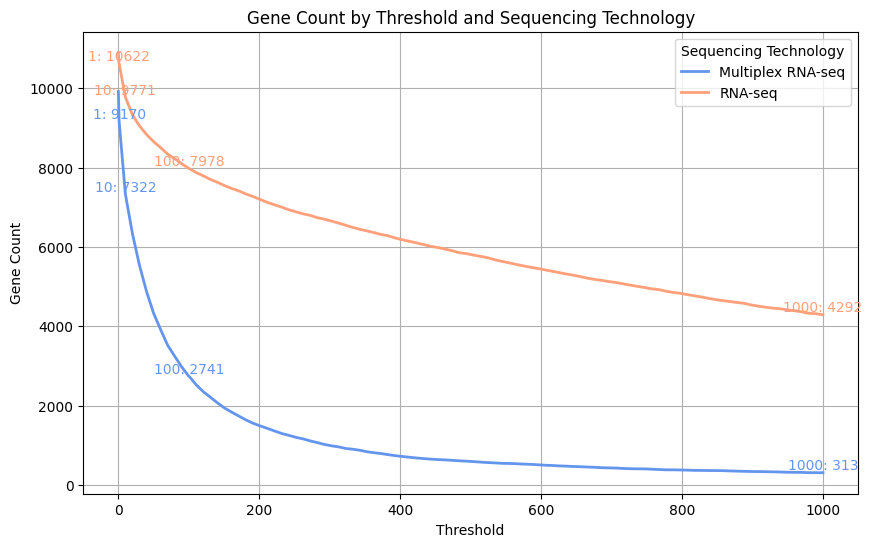

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data creation (you would replace this with your actual DataFrame)
thresholds = sorted(list(np.linspace(0, 1000, 100, dtype=int)) + [1, 10, 100, 1000])
gene_numbers = []  # This should be populated with your actual gene count data
gene_types = []    # This should be populated with your actual sequencing technology types
x_axis = []

# Assuming count_data_alithea and count_data_bulk are defined
for x in thresholds:
    # Filter genes based on the count threshold
    gene_numbers.append(len(set(count_data_alithea[count_data_alithea > x].index)))
    gene_types.append("Multiplex RNA-seq")
    x_axis.append(x)
    gene_numbers.append(len(set(count_data_bulk[count_data_bulk > x].index)))
    gene_types.append("RNA-seq")
    x_axis.append(x)

# Create the DataFrame
data = pd.DataFrame({
    "Threshold": x_axis,
    "Gene Count": gene_numbers,
    "Sequencing technology": gene_types
})

palette = ["cornflowerblue", "lightsalmon"]
# Create the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=data,
    x='Threshold',
    y='Gene Count',
    hue='Sequencing technology',
    marker=None,
    palette=palette,
    lw=2,
)

# Annotate the specific thresholds
for threshold in [1, 10, 100, 1000]:
    for i, tech in enumerate(["Multiplex RNA-seq", "RNA-seq"]):
        value = data[(data['Threshold'] == threshold) & (data['Sequencing technology'] == tech)]['Gene Count']
        if not value.empty:  # Check if the value exists
            
            plt.annotate(
                f'{threshold}: {value.values[0]}', 
                xy=(
                    threshold,
                    value.values[0]
                ), 
                xytext=(
                    threshold,
                    value.values[0]
                ), 
                color=palette[i],
                ha='center',
                va='bottom',
                fontsize=10
            )

plt.title('Gene Count by Threshold and Sequencing Technology')
plt.xlabel('Threshold')
plt.ylabel('Gene Count')
plt.legend(title='Sequencing Technology')
plt.savefig("figures/thresholds.png", dpi=300)
plt.savefig("figures/thresholds.svg", dpi=300)
plt.grid()
plt.show()

In [19]:
data

,Threshold,Gene Count,Sequencing technology
0,0,9912,Multiplex RNA-seq
1,0,10891,RNA-seq
2,1,9170,Multiplex RNA-seq
3,1,10622,RNA-seq
4,10,7322,Multiplex RNA-seq
...,...,...,...
203,989,4319,RNA-seq
204,1000,313,Multiplex RNA-seq
205,1000,4292,RNA-seq
206,1000,313,Multiplex RNA-seq


In [20]:
df = process_dataset(dataset, timepoints)

In [21]:
from collections import defaultdict

bcs2clearname = defaultdict(str)
for i, row in df.iterrows():
    bcs2clearname[row["Metadata_treatments"]] = (
        row["Metadata_Name_Chemical_group"].strip().capitalize()
    )

In [22]:
gene_columns = [col for col in df.columns if not col.startswith("Metadata")]

In [23]:
import pickle

gene_map = pickle.load(open("gene_map.pkl", "rb"))

In [24]:
with open("gene_map.pkl", "wb") as f:
    pickle.dump(gene_map, f)

In [25]:
# df.rename(columns = gene_mapping, inplace=True)
gene_columns = [col for col in df.columns if not col.startswith("Metadata")]

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Array of categories
categories = df["Metadata_FRAC_sub_group"].unique()

# Extract prefixes (text before colon or the full string if no colon exists)
prefixes = [cat.split(":")[0].strip() for cat in categories]

# Get unique prefixes
unique_prefixes = list(set(prefixes))

# Generate a base color for each unique prefix
base_colors = sns.color_palette(
    "Set2", n_colors=len(unique_prefixes)
)  # Use a distinct palette
prefix_color_map = {prefix: base_colors[i] for i, prefix in enumerate(unique_prefixes)}

# Assign colors to each category
category_colors = []
for category in categories:
    prefix = category.split(":")[0].strip()
    base_color = prefix_color_map[prefix]
    category_colors.append(base_color)

# Create a dictionary mapping categories to colors
category_color_map = {cat: color for cat, color in zip(categories, category_colors)}

In [27]:
df["Metadata_Mode_of_Action"].unique()

array(['Respiration', 'Metal homeostasis pertubators',
       'Sterol biosynthesis', 'Cytoskeleton', 'DMSO'], dtype=object)

In [28]:
df["Metadata_FRAC_sub_group"].unique()


array(['C3 Complex III', 'Multisite', 'G1 C14-demethylase',
       'B2 Tubulin polymerization', 'C2 Complex II', 'DMSO',
       'G3 3-keto reductase'], dtype=object)

In [29]:
category_color_map = {
    "Multisite": "darkorange",
    "Metal homeostasis pertubators": "darkorange",
    "DMSO": "grey",
    "Cytoskeleton": "mediumseagreen",
    "B2 Tubulin polymerization": "mediumseagreen",
    "Respiration": "crimson",
    "C2 Complex II": "firebrick",
    "C3 Complex III": "salmon",
    "G1 C14-demethylase": "lightskyblue",
    "G3 3-keto reductase": "royalblue",
    "Sterol biosynthesis": "mediumblue",
}

In [30]:
def select_most_variable_genes(
    expression_df, top_n_genes=None, variance_threshold=None
):
    # Calculate the variance for each gene (assuming genes are in columns and samples in rows)
    variances = expression_df.var(axis=0)

    # If a specific number of top genes is requested
    if top_n_genes is not None:
        most_variable_genes = variances.nlargest(top_n_genes).index
    elif variance_threshold is not None:
        # Select genes above a specified variance threshold
        most_variable_genes = variances[variances > variance_threshold].index
    else:
        # Automatically determine a threshold using the 75th percentile of variance
        threshold = variances.quantile(0.75)
        most_variable_genes = variances[variances > threshold].index

    # Filter the original DataFrame to keep only the most variable genes
    filtered_expression_df = expression_df[most_variable_genes]

    return filtered_expression_df, most_variable_genes

In [31]:
gene_columns = [col for col in df.columns if col in list(gene_map.keys())]

filtered_expression_df, most_variable_genes = select_most_variable_genes(
    df[gene_columns]
)

trival_genes = set(gene_columns) - set(most_variable_genes)
df.drop(columns=trival_genes, inplace=True)


In [32]:
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest


def outlier_pca(df):
    # Assuming df is your DataFrame and cellranger_feats is a list of feature names
    meta_columns = df.columns[df.columns.str.startswith("Metadata_")]
    gene_columns = df.columns[~df.columns.str.startswith("Metadata_")]

    pca = PCA(n_components=2)  # We want to reduce to 2 dimensions for plotting
    principal_components = pca.fit_transform(df[gene_columns])

    envelope = IsolationForest(
        contamination="auto", n_jobs=-1, random_state=42
    )  # Adjust contamination as needed
    envelope.fit(df[gene_columns])
    pca_df = pd.DataFrame(data=principal_components, columns=["PC1", "PC2"])
    pca_df["Metadata_treatments"] = list(df["Metadata_treatments"])
    pca_df["Metadata_log_concentration"] = list(df["Metadata_log_concentration"])

    pca_df["Metadata_Mode_of_Action"] = list(df["Metadata_Mode_of_Action"])
    outlier_list = envelope.predict(df[gene_columns])  # True for outliers
    pca_df["Outlier"] = outlier_list

    # Highlight outliers
    outliers = pca_df[pca_df["Outlier"] == -1]

    df = df[outlier_list != -1]
    return df

In [33]:
# original_df[meta_columns] = df.copy()
# df = outlier_pca(df)

In [34]:
df["Metadata_Name_Chemical_group"].unique()

array(['Pyraclostrobin', 'Reference m2', 'Prochloraz', 'Diethofencarb',
       'Pyrisoxazole', 'Reference c1', 'Tebuconazole', 'Fluopyram',
       'DMSO', 'Fenhexamid', 'Boscalid', 'Fenpyrazamine', 'Isoflucypram',
       'Reference sb1', 'Trifloxystrobin', 'Reference m1',
       'Metltetraprole'], dtype=object)

In [35]:
import anndata
import scanpy as sc

# df.rename(
#    columns = gene_map,
#    inplace = True
# )

# Select gene count columns
gene_columns = [col for col in df.columns if not col.startswith("Metadata")]

var_df = pd.DataFrame(
    {
        "Gene Name": gene_columns,
        "Gene Description": [gene_map[x] if x in gene_map else x for x in gene_columns],
    }
)

var_df.index = gene_columns

# Select metadata columns
metadata_columns = [col for col in df.columns if col.startswith("Metadata")]

/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/anndata

In [38]:
df

,Bcin01g00010,Bcin01g00020,Bcin01g00030,Bcin01g00040,Bcin01g00050,Bcin01g00060,Bcin01g00080,Bcin01g00090,Bcin01g00100,Bcin01g00110,...,Metadata_concentration,Metadata_Timepoints,Metadata_Treatments_and_timepoints,Metadata_BCS-code,Metadata_Fraction_number,Metadata_Name_Chemical_group,Metadata_Real_name,Metadata_Mode_of_Action,Metadata_FRAC_sub_group,Metadata_log_concentration
0,5.564431,5.174952,6.920729,5.807575,4.728326,5.345864,6.148491,5.263459,4.974528,4.152444,...,0.3,24,BCS-AH28139 at 24h,BCS-AH28139,NaN,Pyraclostrobin,NaN,Respiration,C3 Complex III,-0.522879
1,5.184858,4.735838,6.381514,5.703915,4.497456,5.395976,5.542106,5.088594,4.663073,3.981064,...,0.3,24,BCS-AH28139 at 24h,BCS-AH28139,NaN,Pyraclostrobin,NaN,Respiration,C3 Complex III,-0.522879
2,5.330388,4.875367,6.556360,5.505710,4.620566,5.472565,6.013505,5.438520,4.367543,4.367543,...,0.3,24,BCS-AH28139 at 24h,BCS-AH28139,NaN,Pyraclostrobin,NaN,Respiration,C3 Complex III,-0.522879
3,5.798106,5.039704,6.662620,5.363121,5.100237,5.363121,6.014571,5.264825,4.018932,4.209361,...,10,24,BCS-DF19025 at 24h,BCS-DF19025,NaN,Reference m2,PAPYs,Metal homeostasis pertubators,Multisite,1.000000
4,4.559989,4.429281,5.703426,4.866651,4.774778,4.951059,6.011997,4.774778,4.063818,4.429281,...,10.0,24,BCS-AA15826 at 24h,BCS-AA15826,NaN,Prochloraz,NaN,Sterol biosynthesis,G1 C14-demethylase,1.000000
5,3.552407,5.306996,3.552407,5.306996,3.552407,5.306996,5.916148,3.552407,3.552407,3.552407,...,3.0,24,BCS-AI38388 at 24h,BCS-AI38388,NaN,Diethofencarb,NaN,Cytoskeleton,B2 Tubulin polymerization,0.477121
6,4.321594,4.042309,4.770886,4.241983,4.393080,4.678083,4.934156,4.575098,3.552407,4.321594,...,3.0,24,BCS-AI38388 at 24h,BCS-AI38388,NaN,Diethofencarb,NaN,Cytoskeleton,B2 Tubulin polymerization,0.477121
7,4.415449,3.988726,4.415449,4.167149,3.552407,4.167149,5.463833,4.513877,3.552407,3.988726,...,10.0,24,BCS-AA15826 at 24h,BCS-AA15826,NaN,Prochloraz,NaN,Sterol biosynthesis,G1 C14-demethylase,1.000000
8,4.956032,5.261216,5.222246,4.733632,4.443411,5.371079,5.929061,4.351806,4.525489,3.955923,...,10.0,24,BCS-AA15826 at 24h,BCS-AA15826,NaN,Prochloraz,NaN,Sterol biosynthesis,G1 C14-demethylase,1.000000
9,4.170204,4.088444,3.990911,3.990911,4.241836,4.563908,4.830756,4.419677,3.990911,3.863071,...,3.0,24,BCS-AI38388 at 24h,BCS-AI38388,NaN,Diethofencarb,NaN,Cytoskeleton,B2 Tubulin polymerization,0.477121


In [36]:
df = df.reset_index(drop=True)

In [39]:
adata = anndata.AnnData(X=df[gene_columns], obs=df[metadata_columns], var=var_df)

sc.pp.highly_variable_genes(adata, 
                           #min_mean=0.0125,  # Minimum average expression
                           #max_mean=3,       # Maximum average expression
                           #min_disp=0.5,     # Minimum dispersion
                           n_top_genes=500
                           ) # Number of genes to keep

# 2. Filter the object to keep only highly variable genes
adata = adata[:, adata.var.highly_variable]

sc.tl.pca(adata, svd_solver="arpack")

# Compute the neighborhood graph
sc.pp.neighbors(
    adata,
    # n_neighbors=10,
    # n_pcs=20
)

sc.tl.leiden(
    adata,
    # resolution=0.3
)

# Run PAGA
sc.tl.paga(adata, groups="leiden")
sc.pl.paga(adata, plot=False)

# Perform UMAP
sc.tl.umap(adata, init_pos="paga")

# Perform Leiden clustering
sc.tl.leiden(adata)

from matplotlib import rcParams

rcParams["figure.figsize"] = (10, 10)

# Plot UMAP with leiden cluster labels and treatments
# sc.pl.umap(
#     adata,
#     color=['leiden', 'Metadata_Mode_of_Action', "Metadata_FRAC_sub_group"],
#     title='UMAP plot with leiden cluster labels and treatments',
# )
# plt.savefig(f"{self._plot_path}/louvain_clustering_umap.png",  bbox_inches='tight', dpi=300)

/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca


/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = 

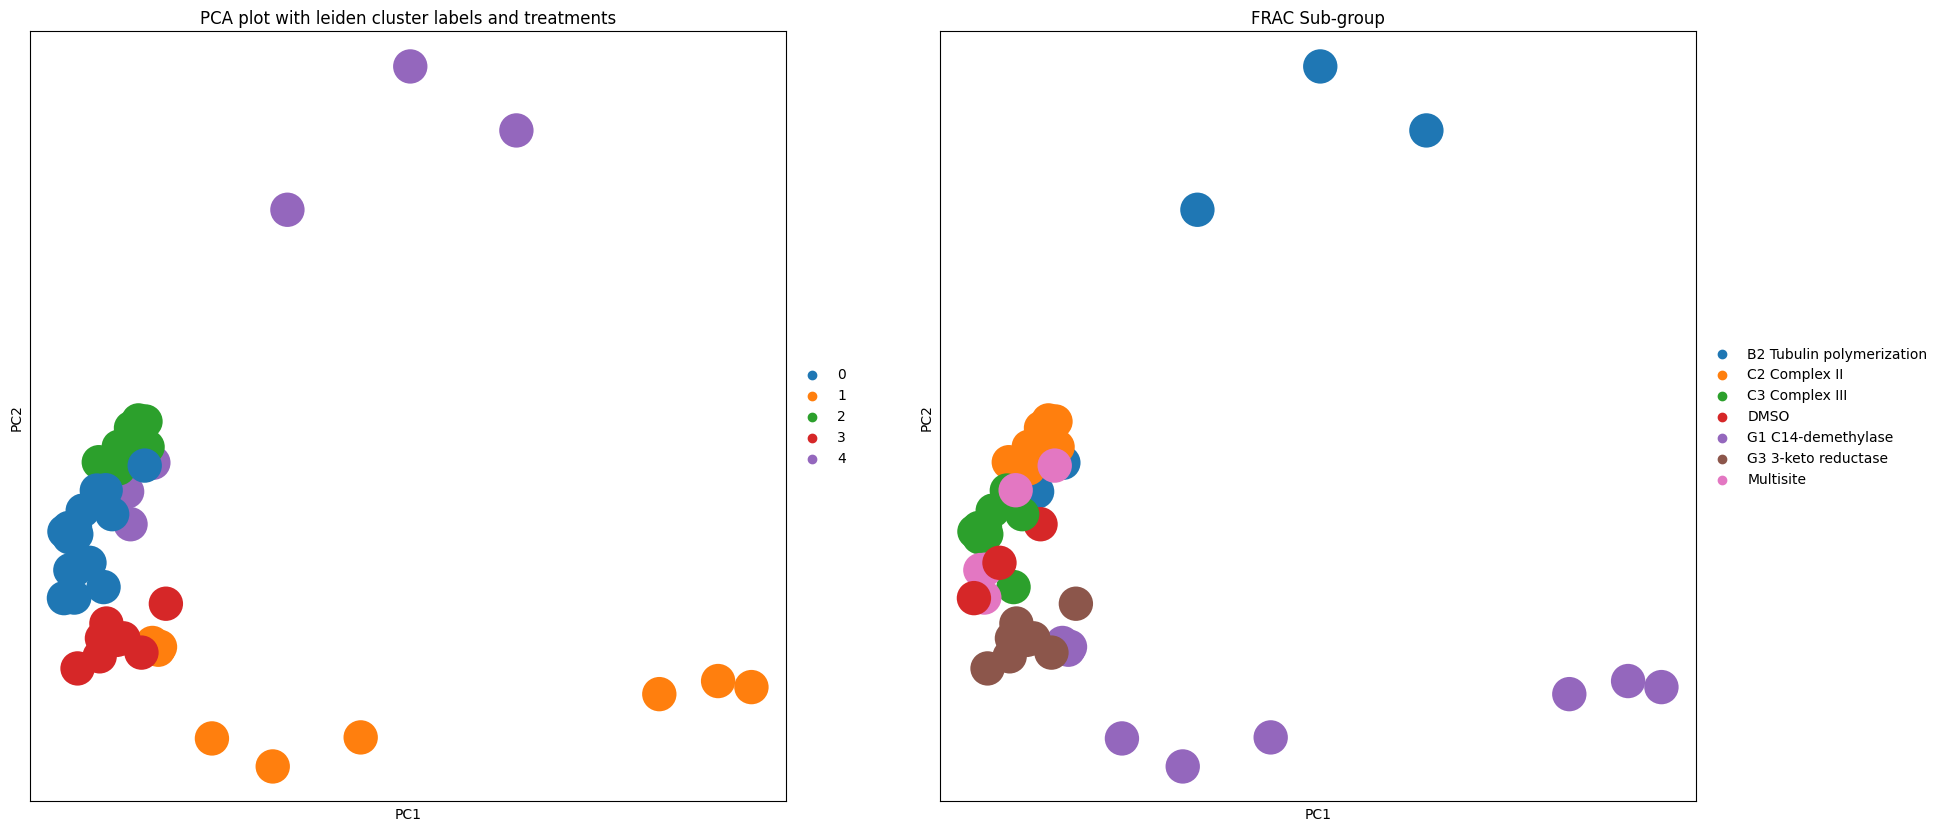

In [49]:
sc.pl.pca(
    adata,
    color=["Leiden Cluster", "FRAC Sub-group"],
    title="PCA plot with leiden cluster labels and treatments",
)

In [40]:
adata.obs.rename(
    columns={
        "Metadata_treatments": "Treatment",
        "Metadata_Mode_of_Action": "Mode of Action",
        "Metadata_FRAC_sub_group": "FRAC Sub-group",
        "Metadata_log_concentration": "Log Concentration",
        "leiden": "Leiden Cluster",
    },
    inplace=True,
)

/tmp/ipykernel_9799/242119607.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for mode, group in adata.obs.groupby("Mode of Action"):


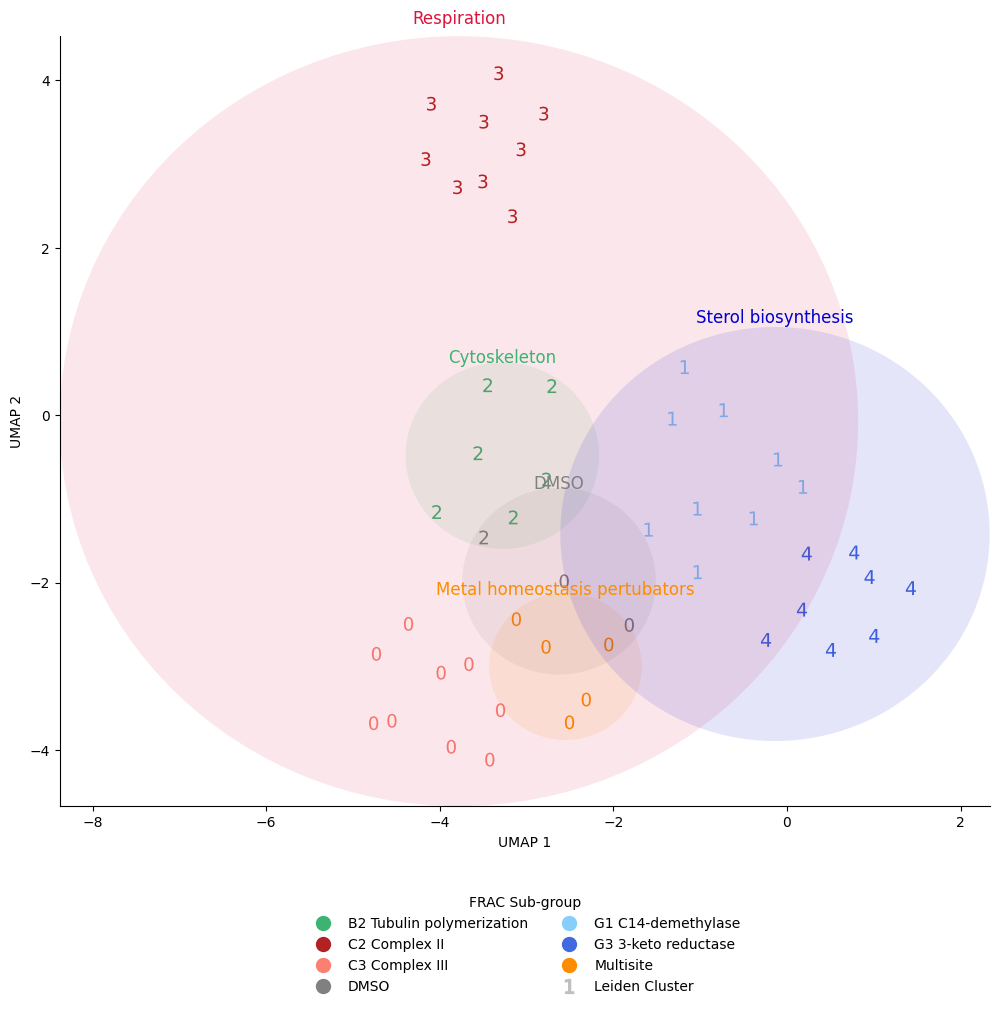

In [41]:
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Circle

adata.obs["UMAP 1"] = adata.obsm["X_umap"][:, 0]
adata.obs["UMAP 2"] = adata.obsm["X_umap"][:, 1]

# Define unique markers for "Metadata_FRAC_sub_group"
markers = [f"${i}$" for i in range(adata.obs["Leiden Cluster"].nunique())]
marker_map = dict(zip(adata.obs["Leiden Cluster"].unique(), markers))

# Plot using matplotlib

category_color_map

fig = plt.figure(figsize=(12, 10))

ax = plt.gca()
sns.scatterplot(
    data=adata.obs,
    x="UMAP 1",
    y="UMAP 2",
    # size = "Log Concentration",
    s=100,
    lw=0,
    hue="FRAC Sub-group",
    palette=category_color_map,
    style="Leiden Cluster",
    markers=marker_map,
    alpha=1,
    ax=ax,
)

min_x = adata.obs["UMAP 1"].min()
min_y = adata.obs["UMAP 2"].min()
max_x = adata.obs["UMAP 1"].max()
max_y = adata.obs["UMAP 2"].max()

# Calculate cluster centers and radii for "Mode of Action"
# Calculate cluster centers and radii for "Mode of Action"
for mode, group in adata.obs.groupby("Mode of Action"):
    # Cluster center
    center_x, center_y = group["UMAP 1"].mean(), group["UMAP 2"].mean()
    # Calculate radius as the maximum distance from the center
    radius = np.sqrt(
        ((group["UMAP 1"] - center_x) ** 2 + (group["UMAP 2"] - center_y) ** 2).max()
    )
    # Update min/max values to include circle boundaries
    min_x = min(min_x, center_x - radius * 1.1)
    max_x = max(max_x, center_x + radius * 1.1)
    min_y = min(min_y, center_y - radius * 1.1)
    max_y = max(max_y, center_y + radius * 1.1)
    # Add circle
    circle = Circle(
        (center_x, center_y),
        radius=radius * 1.1,
        color=category_color_map[mode],
        fill=True,
        # linewidth=1.5,
        linewidth=0,
        alpha=0.1,
        # linestyle="--"
    )
    ax.add_patch(circle)

    # Annotate with Mode of Action above the circle
    ax.text(
        center_x,
        center_y + radius * 1.15,  # Offset to position above the circle
        mode,
        fontsize=12,
        ha="center",
        va="center",
        color=category_color_map[mode],
        # bbox=dict(facecolor="white", edgecolor="none", alpha=0.8)
    )
# plt.title("UMAP Plot with Automatic Circles Around Mode of Action Clusters")
# plt.show()
# ax.set_axis_off()

# Set axis limits
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)

sns.move_legend(
    ax,
    "lower center",
    bbox_to_anchor=(0.5, 1),
    ncol=5,
    title="Legend",
    frameon=False,
)
ax.spines[["right", "top"]].set_visible(False)

# Create custom legend handles for "FRAC Sub-group" with circular markers
legend_handles = [
    Line2D(
        [0],
        [0],
        marker="o",  # Circular marker
        color=category_color_map[group],
        label=group,
        markerfacecolor=category_color_map[group],
        markersize=10,
        linestyle="None",
    )
    for group in sorted(adata.obs["FRAC Sub-group"].unique())
]
legend_handles.append(
    Line2D(
        [0],
        [0],
        marker="$1$",  # Circular marker
        color="silver",
        label="Leiden Cluster",
        # markerfacecolor=category_color_map[group],
        markersize=10,
        linestyle="None",
    )
)

# Add the legend with custom handles
# Add the legend with custom handles
ax.legend(
    handles=legend_handles,
    title="FRAC Sub-group",
    bbox_to_anchor=(0.5, -0.1),  # Position below the plot
    loc="upper center",  # Center the legend below the plot
    ncol=2,  # Arrange legend items in a single row
    frameon=False,  # Remove legend frame
)
plt.savefig("cluster_plot.png", bbox_inches="tight")
plt.savefig("cluster_plot.svg")
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()
# plt.close()

In [42]:
df = df[df["Metadata_Name_Chemical_group"] != ""]
adata = adata[adata.obs["Metadata_Name_Chemical_group"] != ""]



/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()
/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:163: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = dat


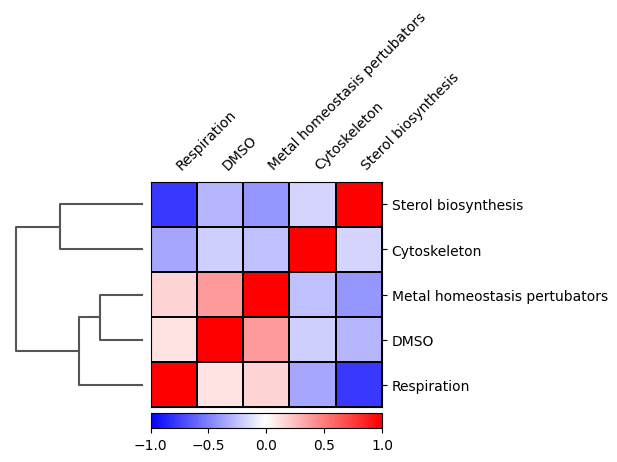

In [43]:
ax = sc.pl.correlation_matrix(
    adata, "Mode of Action", show=True, save="_moa.svg"
)  # Prevents the plot from displaying
# Save the plot to a file
plt.close()

/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()
/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


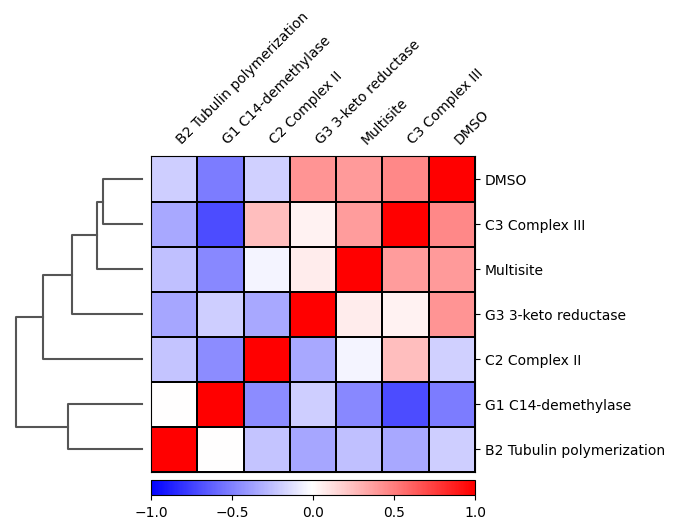

In [45]:
sc.tl.dendrogram(adata, groupby="Metadata_Name_Chemical_group")
ax = sc.pl.correlation_matrix(adata, "FRAC Sub-group", show=True, save="_frac.svg")
plt.close()

In [ ]:
adata.obs.columns

Index(['Treatment', 'Metadata_concentration', 'Metadata_Timepoints',
       'Metadata_Treatments_and_timepoints', 'Metadata_BCS-code',
       'Metadata_Fraction_number', 'Metadata_Name_Chemical_group',
       'Metadata_Real_name', 'Mode of Action', 'FRAC Sub-group',
       'Log Concentration', 'Leiden Cluster', 'UMAP 1', 'UMAP 2'],
      dtype='object')

/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


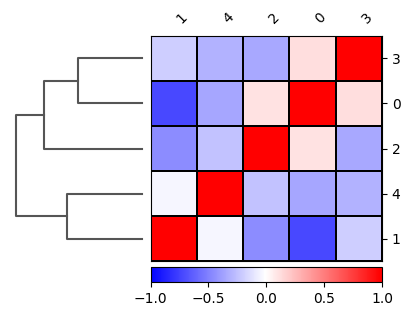

In [46]:
sc.tl.dendrogram(adata, groupby="Leiden Cluster")
ax = sc.pl.correlation_matrix(adata, "Leiden Cluster", show=True, save="_frac.svg")


In [ ]:
df = df[df["Metadata_Name_Chemical_group"] != "Tebuconazole"]

/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


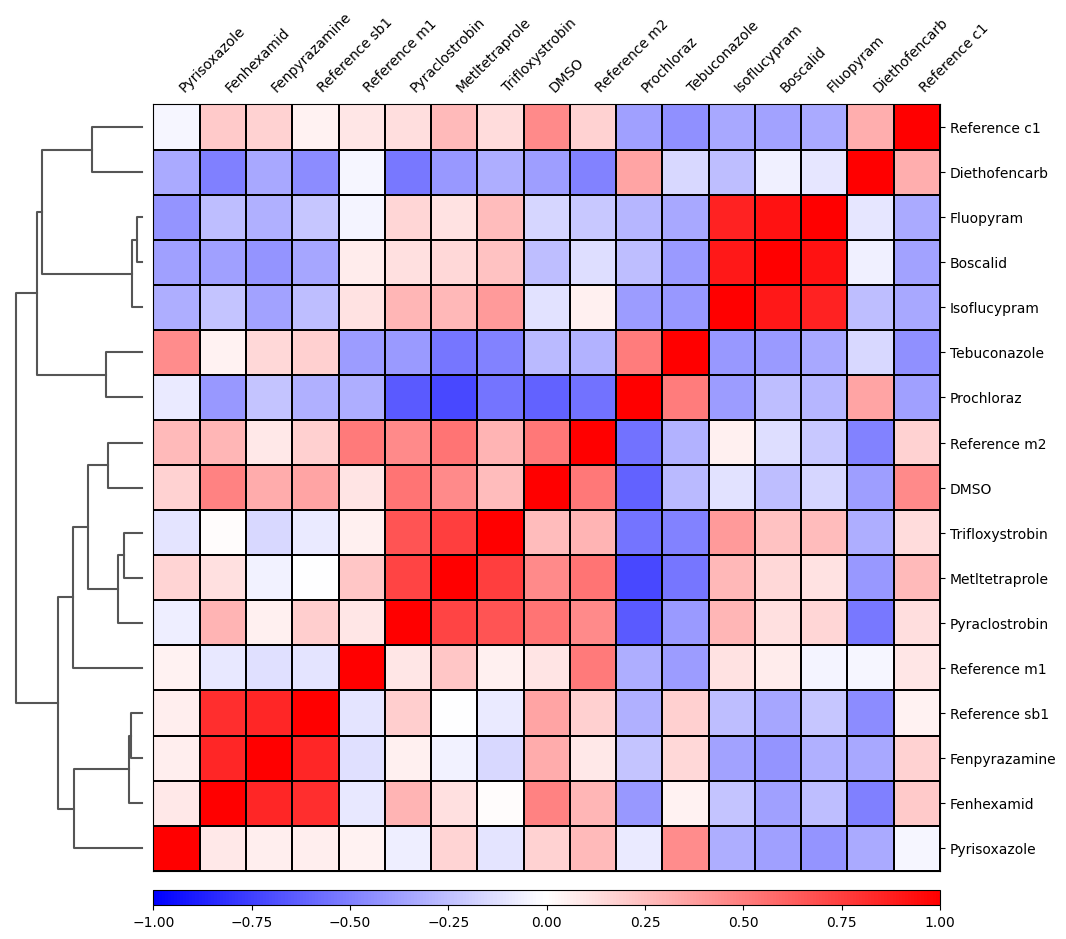

In [47]:
sc.tl.dendrogram(adata, groupby="Metadata_Name_Chemical_group")
ax = sc.pl.correlation_matrix(
    adata, "Metadata_Name_Chemical_group", show=True, save="_treatment.svg"
)
plt.close()

In [ ]:
# adata.obs.head()
sc.tl.dendrogram(adata, "FRAC Sub-group")

/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


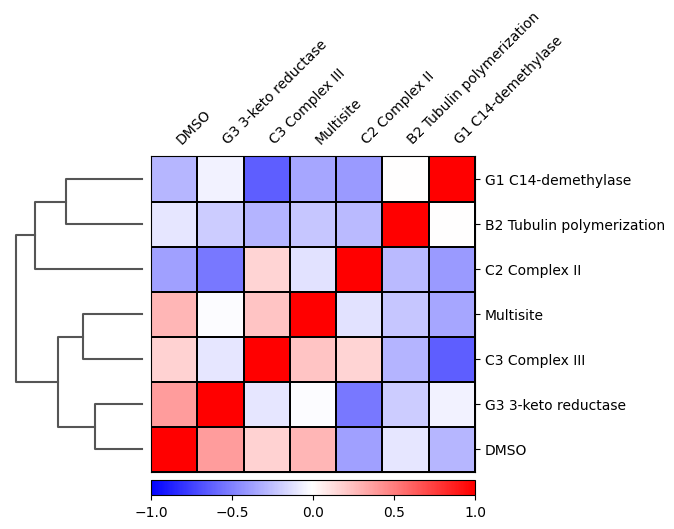

In [ ]:
ax = sc.pl.correlation_matrix(adata, "FRAC Sub-group")

In [89]:
# print(adata.obs["Treatment"].value_counts())

In [90]:
# Count the number of samples for each treatment
treatment_counts = adata.obs["Treatment"].value_counts()

# Filter out treatments with only one sample
valid_treatments = treatment_counts[treatment_counts > 1].index

# Filter the adata object to keep only the valid treatments
adata = adata[adata.obs["Treatment"].isin(valid_treatments)].copy()


In [91]:
# volcano_plot_comparison(adata, "FRAC Sub-group" )

In [92]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from adjustText import adjust_text


def make_volcano(treatment):
    """
    Make an interactive volcano plot as an html. Attach meta data to individual genes.

    Parameters
    ----------
    treatment : string
        Name of the treatment

    Returns
    -------
    fig : object
        The figure object of the volcano plot

    pd.Series : object
        Pandas series containing the log2foldchange. Will be used later for
        colouring in the plot_gene_atlas function
    """
    table = f"/home/ec2-user/sophia_comparison/s3_mount/Experiments/20240731_Lyon_comparison_alithea/DeSeq/Tables/{treatment} at 24_differential_expression.tsv"
    if not os.path.isfile(table):
        table = f"/home/ec2-user/sophia_comparison/s3_mount/Experiments/20240731_Lyon_comparison_alithea/DeSeq/Tables/{treatment}_differential_expression.tsv"

    # Read in data
    data_frame = pd.read_table(table, index_col=0)

    # Convert p-values into -Log10p
    data_frame["-Log10P"] = np.log10(data_frame["padj"]) * -1
    data_frame.loc[data_frame["-Log10P"] < 0, "-Log10P"] = 0

    # Filter for significant Up-regulated and Down-regulated genes
    data_frame["Type hit"] = "Under Threshold"
    data_frame.loc[
        (data_frame["log2FoldChange"] > 1) & (data_frame["padj"] < 0.05), "Type hit"
    ] = "Up-regulated over threshold of P < 0.05 \n and log(2) Fold-Change > 1"
    data_frame.loc[
        (data_frame["log2FoldChange"] < -1) & (data_frame["padj"] < 0.05), "Type hit"
    ] = "Down-regulated over threshold of P < 0.05 \n and log(2) Fold-Change > 1"

    # Filter out non-significant genes
    data_frame.sort_values("-Log10P", ascending=False, inplace=True)

    data_frame.rename(
        columns={
            "log2FoldChange": "Log(2) Fold-Change",
            "-Log10P": "-Log(10) of adjusted P-value",
        },
        inplace=True,
    )

    all_significant = data_frame[
        data_frame["Type hit"] != "Under Threshold"
    ].sort_values("-Log(10) of adjusted P-value", ascending=False)
    filtered_data = all_significant.iloc[:10]

    fig = plt.figure(figsize=(18, 12))

    colour_dict = {
        "Under Threshold": "lightgrey",
        "Up-regulated over threshold of P < 0.05 \n and log(2) Fold-Change > 1": "cornflowerblue",
        "Down-regulated over threshold of P < 0.05 \n and log(2) Fold-Change > 1": "crimson",
    }

    # Make figure
    g = sns.scatterplot(
        data=data_frame,
        x="Log(2) Fold-Change",
        y="-Log(10) of adjusted P-value",
        hue="Type hit",
        alpha=0.6,
        palette=colour_dict,
        legend=True,
        edgecolor="none",
    )

    # Add lines to show thresholds
    ax = plt.gca()
    ax.axhline(y=np.log10(0.05) * -1, lw=2, ls="--", c="grey")
    ax.axvline(x=1, lw=2, ls="--", c="grey")
    ax.axvline(x=-1, lw=2, ls="--", c="grey")
    ax.spines[["right", "top"]].set_visible(False)
    ax.grid(True, alpha=0.2)
    ax.tick_params(axis="both", which="major", labelsize=12)

    texts = []
    for gene, row in filtered_data.iterrows():
        # Check the log2 fold change to determine text position
        if row["Log(2) Fold-Change"] < 1:
            x_offset = 0.05  # Offset to the right
        else:
            x_offset = -0.05  # Offset to the left for better visibility

        texts.append(
            ax.text(
                row["Log(2) Fold-Change"] + x_offset,
                row["-Log(10) of adjusted P-value"] * 1.01,
                f"{gene}",
                fontsize=14,
                color="black",
            )
        )

    # Use adjustText to avoid overlapping labels
    adjust_text(
        texts,
        # expand=(1.1, 1.1),
        # only_move='y',  # Move only in the y direction
        arrowprops=dict(color="silver", lw=1),
    )

    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    treatment = bcs2clearname[treatment]

    fig.suptitle(f"Volcano plot of treatment {treatment}", fontsize=16)
    # plt.savefig(f"figures/volcano_plot_alithea_{treatment}.png",  bbox_inches='tight', dpi=300)
    # plt.savefig(f"figures/volcano_plot_alithea_{treatment}.svg")
    # plt.show()
    plt.close()
    return all_significant


# Note: You may need to adjust the parameters of `adjust_text` based on your specific needs.

In [93]:
def make_volcano_bulk(treatment):
    """
    Make an interactive volcano plot as an html. Attach meta data to individual genes.

    Parameters
    ----------
    treatment : string
        Name of the treatment

    Returns
    -------
    fig : object
        The figure object of the volcano plot

    pd.Series : object
        Pandas series containing the log2foldchange. Will be used later for
        colouring in the plot_gene_atlas function
    """
    table = f"/home/ec2-user/sophia_comparisons3_mount/Experiments/20240731_Lyon_comparison_bulk/DeSeq/Tables/{treatment} at 24_differential_expression.tsv"
    if not os.path.isfile(table):
        table = f"/home/ec2-user/sophia_comparison/s3_mount/Experiments/20240731_Lyon_comparison_bulk/DeSeq/Tables/{treatment}_differential_expression.tsv"

    # Read in data
    data_frame = pd.read_table(table, index_col=0)

    # Convert p-values into -Log10p
    data_frame["-Log10P"] = np.log10(data_frame["padj"]) * -1
    data_frame.loc[data_frame["-Log10P"] < 0, "-Log10P"] = 0

    # Filter for significant Up-regulated and Down-regulated genes
    data_frame["Type hit"] = "Under Threshold"
    data_frame.loc[
        (data_frame["log2FoldChange"] > 1) & (data_frame["padj"] < 0.05), "Type hit"
    ] = "Up-regulated over threshold of P < 0.05 \n and log(2) Fold-Change > 1"
    data_frame.loc[
        (data_frame["log2FoldChange"] < -1) & (data_frame["padj"] < 0.05), "Type hit"
    ] = "Down-regulated over threshold of P < 0.05 \n and log(2) Fold-Change > 1"

    # Filter out non-significant genes
    data_frame.sort_values("-Log10P", ascending=False, inplace=True)

    data_frame.rename(
        columns={
            "log2FoldChange": "Log(2) Fold-Change",
            "-Log10P": "-Log(10) of adjusted P-value",
        },
        inplace=True,
    )

    all_significant = data_frame[
        data_frame["Type hit"] != "Under Threshold"
    ].sort_values("-Log(10) of adjusted P-value", ascending=False)
    filtered_data = all_significant.iloc[:10]

    fig = plt.figure(figsize=(18, 12))

    colour_dict = {
        "Under Threshold": "lightgrey",
        "Up-regulated over threshold of P < 0.05 \n and log(2) Fold-Change > 1": "cornflowerblue",
        "Down-regulated over threshold of P < 0.05 \n and log(2) Fold-Change > 1": "crimson",
    }

    # Make figure
    g = sns.scatterplot(
        data=data_frame,
        x="Log(2) Fold-Change",
        y="-Log(10) of adjusted P-value",
        hue="Type hit",
        alpha=0.6,
        palette=colour_dict,
        legend=True,
        edgecolor="none",
    )

    # Add lines to show thresholds
    ax = plt.gca()
    ax.axhline(y=np.log10(0.05) * -1, lw=2, ls="--", c="grey")
    ax.axvline(x=1, lw=2, ls="--", c="grey")
    ax.axvline(x=-1, lw=2, ls="--", c="grey")
    ax.spines[["right", "top"]].set_visible(False)
    ax.grid(True, alpha=0.2)
    ax.tick_params(axis="both", which="major", labelsize=12)

    texts = []
    for gene, row in filtered_data.iterrows():
        # Check the log2 fold change to determine text position
        if row["Log(2) Fold-Change"] < 1:
            x_offset = 0.05  # Offset to the right
        else:
            x_offset = -0.05  # Offset to the left for better visibility

        texts.append(
            ax.text(
                row["Log(2) Fold-Change"],
                row["-Log(10) of adjusted P-value"],
                f"{gene}",
                fontsize=14,
                color="black",
            )
        )

    # Use adjustText to avoid overlapping labels
    adjust_text(
        texts,
        # expand=(1.1, 1.1),
        # only_move='y',  # Move only in the y direction
        arrowprops=dict(color="silver", lw=1),
    )

    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

    treatment = bcs2clearname[treatment]
    fig.suptitle(f"Volcano plot of treatment {treatment}", fontsize=16)
    # plt.savefig(f"figures/volcano_plot_bulk_{treatment}.png",  bbox_inches='tight', dpi=300)
    # plt.savefig(f"figures/volcano_plot_bulk_{treatment}.svg")
    # plt.show()
    plt.close()
    return all_significant


# Note: You may need to adjust the parameters of `adjust_text` based on your specific needs.

In [94]:
significance_bulk = {}
significance_alithea = {}
for treatment in adata.obs["Treatment"].unique():
    if treatment == "DMSO":
        continue
    significance_alithea[treatment] = make_volcano(treatment)
    significance_bulk[treatment] = make_volcano_bulk(treatment)

In [95]:
# Load the GTF file
gtf_path = "/home/ec2-user/sophia_comparison/s3_mount/RefGenomes/BotrytisCinerea/Botrytis_cinerea.ASM83294v1.59.gtf"

gtf_data = pd.read_csv(gtf_path, sep="\t", comment="#", header=None)
# gtf_data = gtf_data[gtf_data[2] == 'gene']
# Extract gene lengths
gtf_data.columns = [
    "seqname",
    "source",
    "feature",
    "start",
    "end",
    "score",
    "strand",
    "frame",
    "attribute",
]
gtf_data["gene_id"] = gtf_data["attribute"].str.extract('gene_id "([^"]+)"')

# Calculate gene lengths
gtf_data["gene_length"] = gtf_data["end"] - gtf_data["start"]
lengths_dict = dict(zip(gtf_data["gene_id"], gtf_data["gene_length"]))

In [96]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D


def volcano_comparison(treatments):
    """
    Create an interactive volcano plot for multiple treatments and save as HTML.
    Attach meta data to individual genes.

    Parameters
    ----------
    treatments : list of strings
        List of treatment names.

    Returns
    -------
    fig : object
        The figure object of the volcano plot.
    """
    fig, ax = plt.subplots(figsize=(22, 12))
    frac_group, treatments = treatments
    colour_dict = {
        "Under Threshold": "lightgrey",
        "Up-regulated": "cornflowerblue",
        "Down-regulated": "crimson",
    }

    markers = ["o", "X", "D", "^", "v", "p", "*"]
    filtered_dataframes, overlapping_significant_genes = [], []

    for i, treatment in enumerate(treatments):
        table_path = f"/home/ec2-user/sophia_comparison/s3_mount/Experiments/20240731_Lyon_comparison_alithea/DeSeq/Tables/{treatment} at 24_differential_expression.tsv"
        if not os.path.isfile(table_path):
            table_path = f"/home/ec2-user/sophia_comparison/s3_mount/Experiments/20240731_Lyon_comparison_alithea/DeSeq/Tables/{treatment}_differential_expression.tsv"

        data_frame = pd.read_table(table_path, index_col=0)
        data_frame["-Log10P"] = np.maximum(-np.log10(data_frame["padj"]), 0)
        data_frame["Type hit"] = "Under Threshold"
        data_frame.loc[
            (data_frame["log2FoldChange"].abs() > 1) & (data_frame["padj"] < 0.05),
            "Type hit",
        ] = "Up-regulated"
        data_frame.rename(
            columns={
                "log2FoldChange": "Log(2) Fold-Change",
                "-Log10P": "-Log(10) of adjusted P-value",
            },
            inplace=True,
        )

        significant_data = data_frame[
            data_frame["Type hit"] != "Under Threshold"
        ].sort_values("-Log(10) of adjusted P-value", ascending=False)
        significant_data["Treatment"] = treatment
        filtered_dataframes.append(significant_data)
        overlapping_significant_genes.append(set(significant_data.index))

        sns.scatterplot(
            data=data_frame,
            x="Log(2) Fold-Change",
            y="-Log(10) of adjusted P-value",
            alpha=0.6,
            color="gainsboro",
            edgecolor="none",
            marker=markers[i % len(markers)],
            ax=ax,
        )

    intersection_of_genes = set.intersection(*overlapping_significant_genes)
    n = min(len(intersection_of_genes), 10)
    colors = plt.get_cmap("tab10")(np.linspace(0, 1, n))

    overlapping_gene_data = pd.concat(
        [df[df.index.isin(intersection_of_genes)] for df in filtered_dataframes], axis=0
    )

    if not overlapping_gene_data.empty:
        overlapping_gene_data["Top 10 overlapping\ngenes by significance"] = (
            overlapping_gene_data.index
        )
        top_genes = (
            overlapping_gene_data.groupby("Top 10 overlapping\ngenes by significance")[
                "-Log(10) of adjusted P-value"
            ]
            .max()
            .nlargest(10)
            .index
        )
        overlapping_gene_data = overlapping_gene_data[
            overlapping_gene_data["Top 10 overlapping\ngenes by significance"].isin(
                top_genes
            )
        ]

        # Sort the overlapping_gene_data by -Log(10) of adjusted P-value in descending order
        overlapping_gene_data = overlapping_gene_data.sort_values(
            "-Log(10) of adjusted P-value", ascending=False
        )

        # Create a sorted list of unique genes based on their order in the sorted DataFrame
        sorted_genes = overlapping_gene_data[
            "Top 10 overlapping\ngenes by significance"
        ].unique()

        for i, gene in enumerate(sorted_genes):
            subset = overlapping_gene_data[
                overlapping_gene_data["Top 10 overlapping\ngenes by significance"]
                == gene
            ]
            ax.plot(
                subset["Log(2) Fold-Change"],
                subset["-Log(10) of adjusted P-value"],
                ls="--",
                alpha=0.4,
                c=colors[i],
            )

        overlapping_gene_data["Top 10 overlapping\ngenes by significance"] = [
            gene_map[x].split(",")[0]
            for x in overlapping_gene_data["Top 10 overlapping\ngenes by significance"]
        ]

        sns.scatterplot(
            data=overlapping_gene_data,
            x="Log(2) Fold-Change",
            y="-Log(10) of adjusted P-value",
            hue="Top 10 overlapping\ngenes by significance",
            style="Treatment",
            markers=markers[: len(intersection_of_genes)],
            palette=colors,
            s=100,
            edgecolor="white",
            linewidth=1,
            ax=ax,
        )
    # Add threshold lines
    ax.axhline(y=-np.log10(0.05), lw=2, ls="--", c="grey")
    ax.axvline(x=1, lw=2, ls="--", c="grey")
    ax.axvline(x=-1, lw=2, ls="--", c="grey")

    ax.spines[["right", "top"]].set_visible(False)
    ax.grid(True, alpha=0.2)
    ax.tick_params(axis="both", which="major", labelsize=12)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

    ax.set_title(f"Volcano Plot of FRAC-Group {frac_group}", fontsize=16)
    plt.savefig(f"figures/volcano_plot_{frac_group}.png", bbox_inches="tight", dpi=300)
    plt.savefig(f"figures/volcano_plot_{frac_group}.svg")
    plt.show()
    
    return set.intersection(*overlapping_significant_genes)

In [97]:
# # ... [rest of your code above remains unchanged]

# for i, data_frame in enumerate(filtered_dataframes):
#     fig, ax = plt.subplots(figsize=(18, 12))
#     colour_dict = {
#         "Under Threshold": "lightgrey",
#         "Up-regulated over threshold of P < 0.05 \n and log(2) Fold-Change > 1": "cornflowerblue",
#         "Down-regulated over threshold of P < 0.05 \n and log(2) Fold-Change > 1": "crimson",
#     }

#     # Make figure
#     g = sns.scatterplot(
#         data=data_frame,
#         x="Log(2) Fold-Change",
#         y="-Log(10) of adjusted P-value",
#         hue="Type hit",
#         hue_order=[
#             "Up-regulated over threshold of P < 0.05 \n and log(2) Fold-Change > 1",
#             "Down-regulated over threshold of P < 0.05 \n and log(2) Fold-Change > 1",
#             "Under Threshold",
#         ],
#         alpha=0.6,
#         palette=colour_dict,
#         legend=False,
#         edgecolor="none",
#     )

#     filtered_data = data_frame[data_frame.index.isin(intersection_of_genes)]
#     texts = []
#     for gene, row in filtered_data.iterrows():
#         # Check the log2 fold change to determine text position
#         x_offset = 0.05 if row["Log(2) Fold-Change"] < 1 else -0.05
#         gene_text = gene_map[gene].split(",")[0]
#         gene_text = " ".join(
#             [
#                 word if i % 2 == 0 else word + "\n"
#                 for i, word in enumerate(gene_text.split())
#             ]
#         ).replace(" \n", "\n")
#         texts.append(
#             ax.text(
#                 row["Log(2) Fold-Change"] + x_offset,
#                 row["-Log(10) of adjusted P-value"],
#                 gene_text,
#                 fontsize=14,
#                 color="black",
#                 bbox=dict(
#                     facecolor="white",
#                     edgecolor="silver",
#                     alpha=0.4,
#                     boxstyle="round,pad=0.5",
#                 ),
#             )
#         )

#     # Use adjustText to avoid overlapping labels
#     adjust_text(
#         texts,
#         expand=(2, 2),  # Increased expand value for more spacing
#         arrowprops=dict(arrowstyle="<-", color="grey", lw=2),
#     )

#     ax.axhline(y=np.log10(0.05) * -1, lw=2, ls="--", c="grey")
#     ax.axvline(x=1, lw=2, ls="--", c="grey")
#     ax.axvline(x=-1, lw=2, ls="--", c="grey")
#     ax.spines[["right", "top"]].set_visible(False)
#     ax.grid(True, alpha=0.2)
#     ax.tick_params(axis="both", which="major", labelsize=12)

#     treatment = bcs2clearname[treatment]
#     fig.suptitle(f"Volcano Plot for {treatment_name} in {timepoints[i]} ", fontsize=16)
#     plt.savefig(
#         f"figures/separate_volcano_plot_{treatment_name}{timepoints[i]}.png".replace(
#             " ", "_"
#         ),
#         bbox_inches="tight",
#         dpi=300,
#     )
#     plt.savefig(
#         f"figures/separate_volcano_plot_{treatment_name}{timepoints[i]}.svg".replace(
#             " ", "_"
#         )
#     )
#     plt.show()
#     plt.close()

In [98]:
adata.obs["Treatment"] = adata.obs["Treatment"].astype(str)
treatment_groupings = list(adata.obs.groupby(["FRAC Sub-group"])["Treatment"])
treatment_groupings = [
    (x[0][0], list(x[1].unique())) for x in treatment_groupings if len(x[1]) > 1
]
treatment_groupings = [x for x in treatment_groupings if len(x[1]) > 1]

/tmp/ipykernel_12720/3417308985.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  treatment_groupings = list(adata.obs.groupby(["FRAC Sub-group"])["Treatment"])


In [105]:
# for grouping in treatment_groupings:
#     volcano_comparison(grouping)

In [100]:
from adjustText import adjust_text

os.chdir("/home/ec2-user/sophia_comparison/")
from glob import glob


def volcano_comparison_seperate_plots(treatment, n_top_genes=20):
    """
    Create an interactive volcano plot for multiple treatments and save as HTML.
    Attach meta data to individual genes.

    Parameters
    ----------
    treatments : list of strings
        List of treatment names.

    Returns
    -------
    fig : object
        The figure object of the volcano plot.
    """
    treatment_name = treatment
    treatment_name = bcs2clearname[treatment_name]

    markers = [
        "o",
        "s",
        "D",
        "^",
        "v",
        "p",
        "*",
        "X",
    ]  # Different markers for each treatment
    texts = []

    overlapping_significant_genes = []
    filtered_dataframes = []
    legend_handles = []
    table_alithea = f"/home/ec2-user/sophia_comparison/s3_mount/Experiments/20240731_Lyon_comparison_alithea/DeSeq/Tables/{treatment} at 24_differential_expression.tsv"
    table_bulk = f"/home/ec2-user/sophia_comparison/s3_mount/Experiments/20240731_Lyon_comparison_bulk/DeSeq/Tables/{treatment} at 24_differential_expression.tsv"
    if not os.path.isfile(table_alithea) or not os.path.isfile(table_bulk):
        table_alithea = f"/home/ec2-user/sophia_comparison/s3_mount/Experiments/20240731_Lyon_comparison_alithea/DeSeq/Tables/{treatment}_differential_expression.tsv"
        table_bulk = f"/home/ec2-user/sophia_comparison/s3_mount/Experiments/20240731_Lyon_comparison_bulk/DeSeq/Tables/{treatment}_differential_expression.tsv"
        if not os.path.isfile(table_alithea) or not os.path.isfile(table_bulk):
            print(treatment_name)
            print(list(glob(table_alithea.split(" ")[0])))
            print(list(glob(table_bulk.split(" ")[0])))
            print(f"Missing files for {treatment}")
            plt.close()
            return
    treatment = bcs2clearname[treatment]

    timepoints = ["Multiplexed RNAseq", "Bulk RNAseq"]

    for i, table in enumerate([table_alithea, table_bulk]):
        data_frame = pd.read_table(table, index_col=0)
        # Convert p-values into -Log10p
        data_frame["-Log10P"] = np.log10(data_frame["padj"]) * -1
        data_frame.loc[data_frame["-Log10P"] < 0, "-Log10P"] = 0

        # Filter for significant Up-regulated and Down-regulated genes
        data_frame["Type hit"] = "Under Threshold"
        data_frame.loc[
            (data_frame["log2FoldChange"] > 1) & (data_frame["padj"] < 0.05), "Type hit"
        ] = "Up-regulated over threshold of P < 0.05 \n and log(2) Fold-Change > 1"
        data_frame.loc[
            (data_frame["log2FoldChange"] < -1) & (data_frame["padj"] < 0.05),
            "Type hit",
        ] = "Down-regulated over threshold of P < 0.05 \n and log(2) Fold-Change > 1"
        # Filter out non-significant genes
        data_frame.sort_values("-Log10P", ascending=False, inplace=True)

        data_frame.rename(
            columns={
                "log2FoldChange": "Log(2) Fold-Change",
                "-Log10P": "-Log(10) of adjusted P-value",
            },
            inplace=True,
        )

        significant_data = (
            data_frame[data_frame["Type hit"] != "Under Threshold"]
            .sort_values("-Log(10) of adjusted P-value", ascending=False)
            .head(n_top_genes)
        )
        significant_data["Technology"] = timepoints[i]
        filtered_dataframes.append(data_frame)
        overlapping_significant_genes.append(set(significant_data.index))

    intersection_of_genes = set.intersection(*overlapping_significant_genes)
    n = min(len(intersection_of_genes), 10)
    colors = plt.get_cmap("tab10")(np.linspace(0, 1, n))

    overlapping_gene_data = pd.concat(
        [df[df.index.isin(intersection_of_genes)] for df in filtered_dataframes], axis=0
    )

    for i, data_frame in enumerate(filtered_dataframes):
        fig, ax = plt.subplots(figsize=(18, 12))
        colour_dict = {
            "Under Threshold": "lightgrey",
            "Up-regulated over threshold of P < 0.05 \n and log(2) Fold-Change > 1": "cornflowerblue",
            "Down-regulated over threshold of P < 0.05 \n and log(2) Fold-Change > 1": "crimson",
        }

        # Make figure
        g = sns.scatterplot(
            data=data_frame,
            x="Log(2) Fold-Change",
            y="-Log(10) of adjusted P-value",
            hue="Type hit",
            hue_order=[
                "Up-regulated over threshold of P < 0.05 \n and log(2) Fold-Change > 1",
                "Down-regulated over threshold of P < 0.05 \n and log(2) Fold-Change > 1",
                "Under Threshold",
            ],
            alpha=0.6,
            palette=colour_dict,
            legend=False,
            edgecolor="none",
        )

        filtered_data = data_frame[data_frame.index.isin(intersection_of_genes)]
        texts = []
        for gene, row in filtered_data.iterrows():
            # Check the log2 fold change to determine text position
            x_offset = 0.05 if row["Log(2) Fold-Change"] < 1 else -0.05
            gene_text = gene_map[gene].split(",")[0]
            gene_text = " ".join(
                [
                    word if i % 2 == 0 else word + "\n"
                    for i, word in enumerate(gene_text.split())
                ]
            ).replace(" \n", "\n")
            texts.append(
                ax.text(
                    row["Log(2) Fold-Change"] + x_offset,
                    row["-Log(10) of adjusted P-value"],
                    gene_text,
                    fontsize=16,
                    color="black",
                    bbox=dict(
                        facecolor="white",
                        edgecolor="silver",
                        alpha=0.4,
                        boxstyle="round,pad=0.5",
                    ),
                )
            )

        # Use adjustText to avoid overlapping labels
        adjust_text(
            texts,
            expand=(2, 2),  # Increased expand value for more spacing
            arrowprops=dict(arrowstyle="<-", color="grey", lw=2),
        )

        ax.axhline(y=np.log10(0.05) * -1, lw=2, ls="--", c="grey")
        ax.axvline(x=1, lw=2, ls="--", c="grey")
        ax.axvline(x=-1, lw=2, ls="--", c="grey")
        ax.spines[["right", "top"]].set_visible(False)
        ax.grid(True, alpha=0.2)
        ax.tick_params(axis="both", which="major", labelsize=12)

        treatment = bcs2clearname[treatment]
        print(treatment_name)
        print(timepoints[i])
        num_sig = data_frame[data_frame["Type hit"] != "Under Threshold"].shape[0]
        print(f"Number of significant genes: {num_sig}")
        print(f"Maximum log2 fold change: {data_frame['Log(2) Fold-Change'].max():.2f}")
        print("="*10)
        # fig.suptitle(f"Volcano Plot for {treatment_name} in {timepoints[i]} ", fontsize=16)
        plt.savefig(
            f"figures/separate_volcano_plot_{treatment_name}{timepoints[i]}.png".replace(
                " ", "_"
            ),
            bbox_inches="tight",
            dpi=300,
        )
        # plt.savefig(f"figures/separate_volcano_plot_{treatment_name}{timepoints[i]}.svg".replace(" ", "_"))
        #plt.show()
        plt.close()
        
        return set.intersection(*overlapping_significant_genes)

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler

count_data_alithea = pd.read_csv("Lyon_alithea_raw.csv", index_col = 0)
count_data_bulk = pd.read_csv("Lyon_bulk_raw.csv", index_col = 0)

# Calculate CV function
def calculate_cv(counts_df):
    """Calculate coefficient of variation for each gene across samples."""
    # Calculate CV (std/mean) for each gene (row)
    cv = counts_df.std(axis=0) / counts_df.mean(axis=0)
    return cv


def calc_cv(count_data_alithea, count_data_bulk, treatment, genes):
    # Load the count data
    count_data_alithea = count_data_alithea[count_data_alithea["Metadata_Timepoints"] == 24]
    count_data_bulk = count_data_bulk[count_data_bulk["Metadata_Timepoints"] == 24]

    count_data_bulk = count_data_bulk.loc[count_data_bulk["Metadata_treatments"] == treatment, :]
    count_data_alithea = count_data_alithea.loc[count_data_alithea["Metadata_treatments"] == treatment, :]

    gene_columns_alithea = [col for col in count_data_alithea.columns if not col.startswith("Metadata_")]
    gene_columns_bulk = [col for col in count_data_bulk.columns if not col.startswith("Metadata_")]

    count_data_alithea = count_data_alithea[gene_columns_alithea]
    count_data_bulk = count_data_bulk[gene_columns_bulk]

    count_data_alithea = count_data_alithea.astype(int)
    count_data_bulk = count_data_bulk.astype(int)

    # Calculate CVs for both datasets
    gene_cv_multirna = calculate_cv(count_data_alithea)
    gene_cv_traditional = calculate_cv(count_data_bulk)

    # Create figure with two subplots sharing x-axis
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    # Plot MultiRNA-seq CV distribution
    sns.histplot(gene_cv_multirna, bins=100, ax=ax1, element = "step", kde = True, line_kws={'lw': 0})
    ax1.set_title('Distribution of Coefficient of Variation across genes for MultiRNA-seq')
    ax1.set_ylabel('Count')
    ax1.axvline(gene_cv_multirna.median(), color='black', linestyle='--', 
            label=f'Median CV: {gene_cv_multirna.median():.3f}')
    ax1.legend()

    # Plot traditional RNA-seq CV distribution
    sns.histplot(gene_cv_traditional, bins=100, ax=ax2, element = "step", kde = True, line_kws={'lw': 0})
    ax2.set_title('Distribution of Coefficient of Variation across genes for traditional RNA-seq')
    ax2.set_xlabel('CV')
    ax2.set_ylabel('Count')
    ax2.axvline(gene_cv_traditional.median(), color='black', linestyle='--', 
            label=f'Median CV: {gene_cv_traditional.median():.3f}')
    ax2.legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

# for treatment in count_data_alithea["Metadata_treatments"].unique():
#     calc_cv(count_data_alithea, count_data_bulk, treatment)
#     print("="*10)

In [103]:
treatments_for_overlaps = ["BCS-AI38388", "BCS-CN88460", "BCS-AA31476", "BCS-BY16023"]

In [107]:
len(overlapping_genes)

5

Treatment: BCS-AI38388
Diethofencarb
Multiplexed RNAseq
Number of significant genes: 1335
Maximum log2 fold change: 8.57


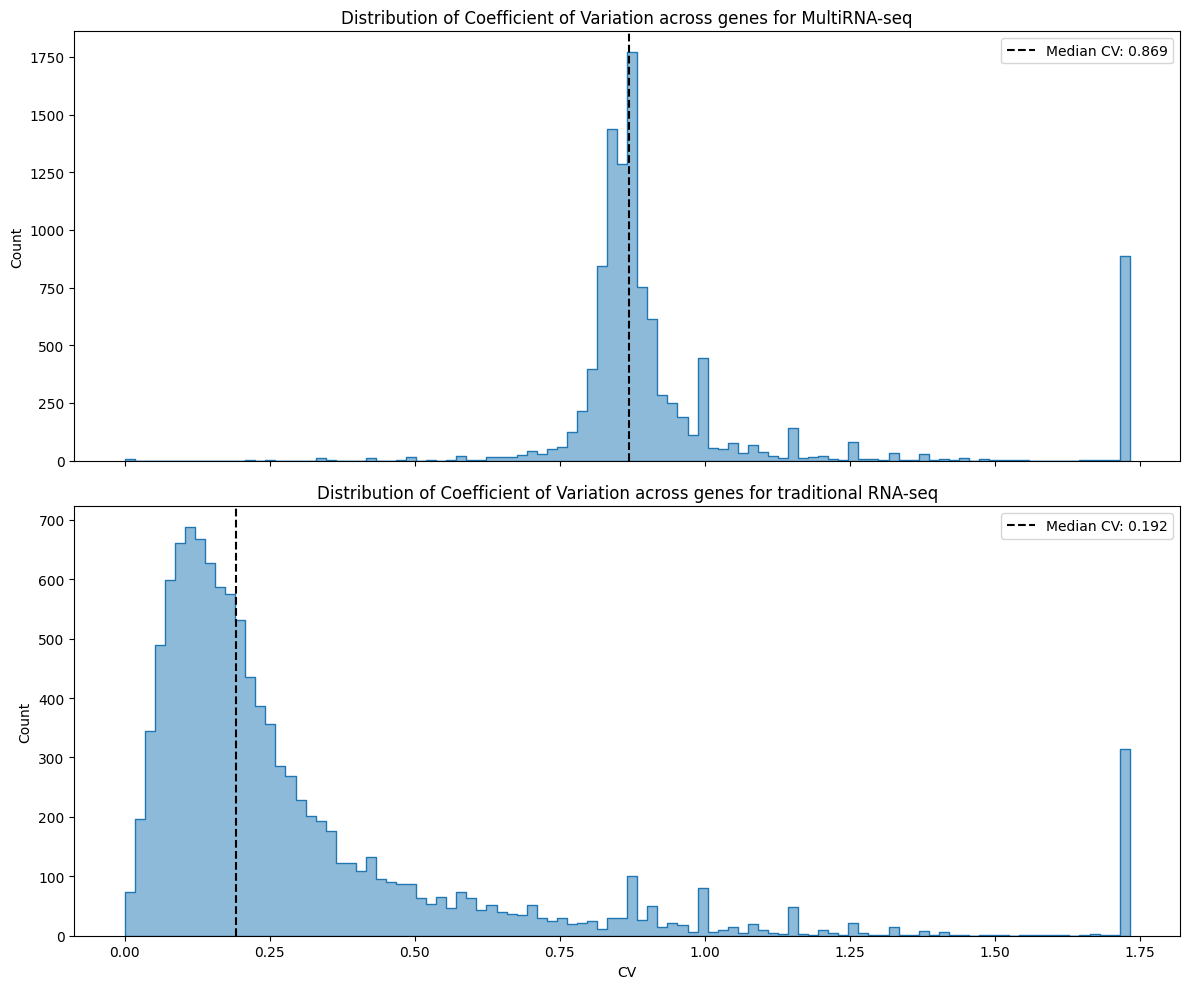

Treatment: BCS-CN88460
Isoflucypram
Multiplexed RNAseq
Number of significant genes: 659
Maximum log2 fold change: 4.45


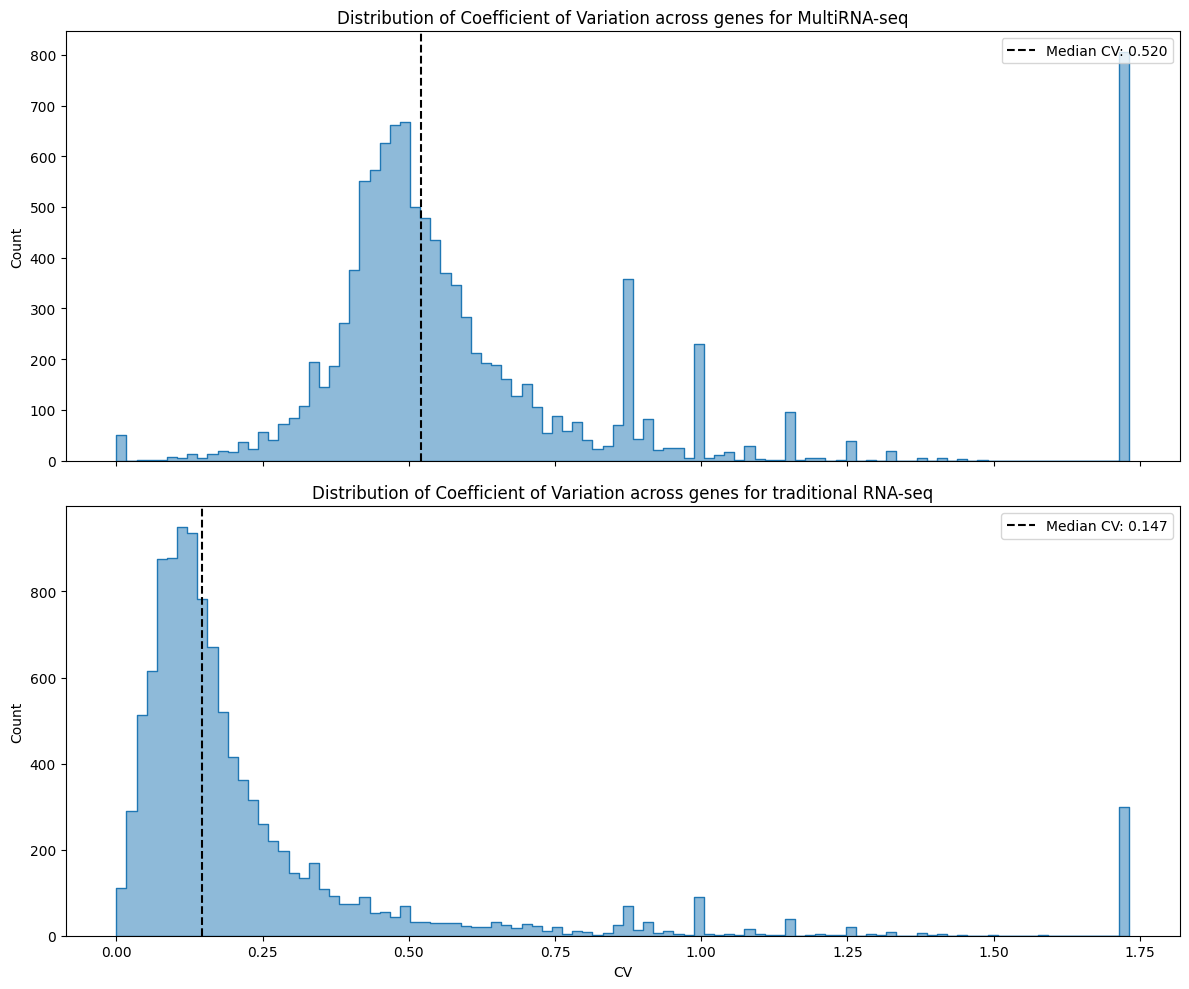

Treatment: BCS-AA31476
Tebuconazole
Multiplexed RNAseq
Number of significant genes: 387
Maximum log2 fold change: 7.82


/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


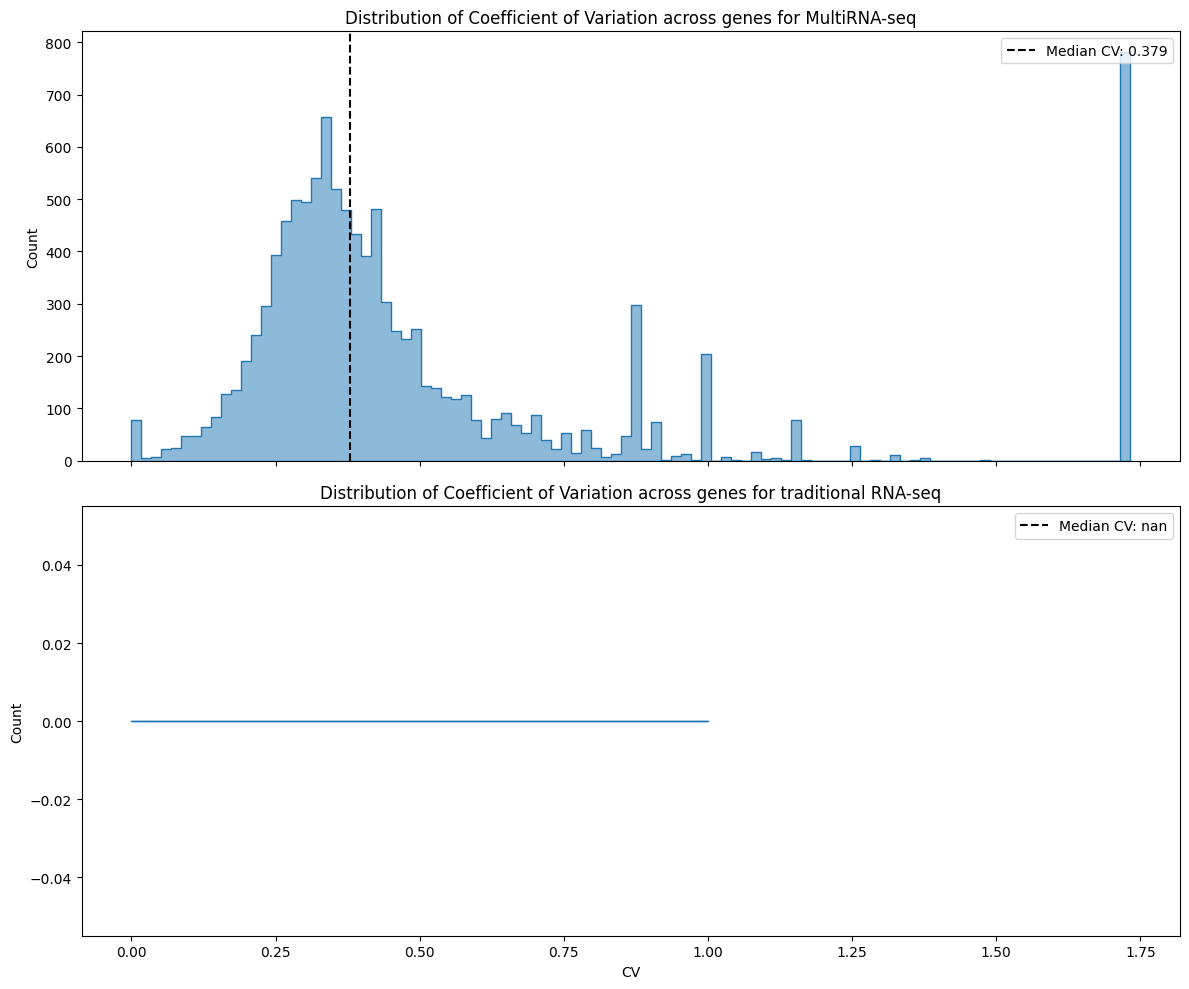

Treatment: BCS-BY16023
Reference m1
Multiplexed RNAseq
Number of significant genes: 317
Maximum log2 fold change: 5.29


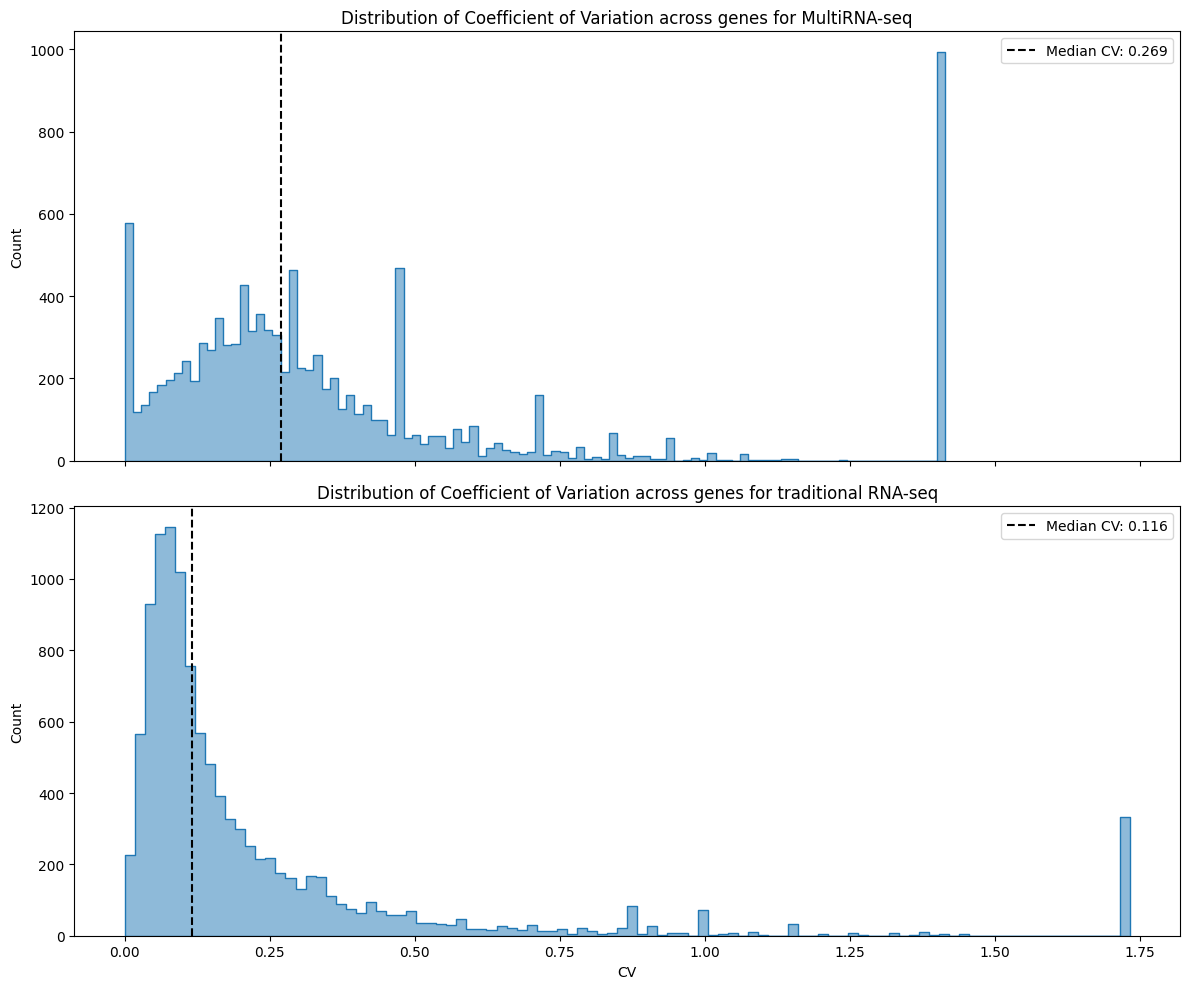

In [113]:
for treatment in treatments_for_overlaps:
    print(f"Treatment: {treatment}")
    overlapping_genes = volcano_comparison_seperate_plots(treatment, n_top_genes=10)
    calc_cv(count_data_alithea.copy(), count_data_bulk.copy(), treatment, list(overlapping_genes))

In [114]:
df_normalised_alithea = process_dataset("Alithea_Lyon_normalised_deseq.csv", timepoints)
df_normalised_bulk = process_dataset("Lyon_bulk_normalised_deseq.csv", timepoints)
df_raw_alithea = process_dataset("Lyon_alithea_raw.csv", timepoints)
df_raw_bulk = process_dataset("Lyon_bulk_raw.csv", timepoints)

In [115]:
from umap import UMAP


def make_embedding(
    df, type_embedding, title, treatments_of_interest, category_color_map
):
    feature_columns = [col for col in df.columns if not col.startswith("Metadata_")]
    meta_columns = [col for col in df.columns if col.startswith("Metadata_")]
    variances = df[feature_columns].var().sort_values(ascending=False)
    top_columns = variances.head(500).index.tolist()
    df = df[top_columns + meta_columns]
    feature_columns = [col for col in df.columns if not col.startswith("Metadata_")]

    df.rename(
        columns={
            "Metadata_treatments": "Treatment",
            "Metadata_Mode_of_Action": "Mode of Action",
            "Metadata_FRAC_sub_group": "FRAC Sub-group",
            "Metadata_log_concentration": "Log Concentration",
        },
        inplace=True,
    )

    if type_embedding == "UMAP":
        embedder = UMAP().fit_transform(df[feature_columns])
        x = "UMAP 1"
        y = "UMAP 2"
    else:
        embedder = PCA().fit_transform(df[feature_columns])
        if "Multiplexed" in title:
            x = "PC1"
            y = "PC2"
        else:
            # embedder[:, 1] = -embedder[:, 1]
            y = "PC1"
            x = "PC2"

    df[x] = embedder[:, 0]
    df[y] = embedder[:, 1]

    # Define unique markers for "Metadata_FRAC_sub_group"
    # Plot using matplotlib

    fig = plt.figure(figsize=(12, 10))

    ax = plt.gca()
    sns.scatterplot(
        data=df,
        x=x,
        y=y,
        # size = "Log Concentration",
        s=100,
        lw=0,
        hue="FRAC Sub-group",
        palette=category_color_map,
        alpha=1,
        ax=ax,
    )

    # Create custom legend handles for "FRAC Sub-group" with circular markers
    legend_handles = [
        Line2D(
            [0],
            [0],
            marker="o",  # Circular marker
            color=category_color_map[group],
            label=group,
            markerfacecolor=category_color_map[group],
            markersize=10,
            linestyle="None",
        )
        for group in sorted(adata.obs["FRAC Sub-group"].unique())
    ]

    fig.suptitle(title)
    # Add the legend with custom handles
    # Add the legend with custom handles
    ax.legend(
        handles=legend_handles,
        title="FRAC Sub-group",
        bbox_to_anchor=(0.5, -0.1),  # Position below the plot
        loc="upper center",  # Center the legend below the plot
        ncol=2,  # Arrange legend items in a single row
        frameon=False,  # Remove legend frame
    )
    plt.savefig(f"figures/{title}.png", bbox_inches="tight", dpi=300)
    plt.savefig(f"figures/{title}.svg", dpi=300)

    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.show()
    plt.close()

/tmp/ipykernel_12720/2633496962.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(
/tmp/ipykernel_12720/2633496962.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[x] = embedder[:, 0]
/tmp/ipykernel_12720/2633496962.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[y] = embedder[:, 1]


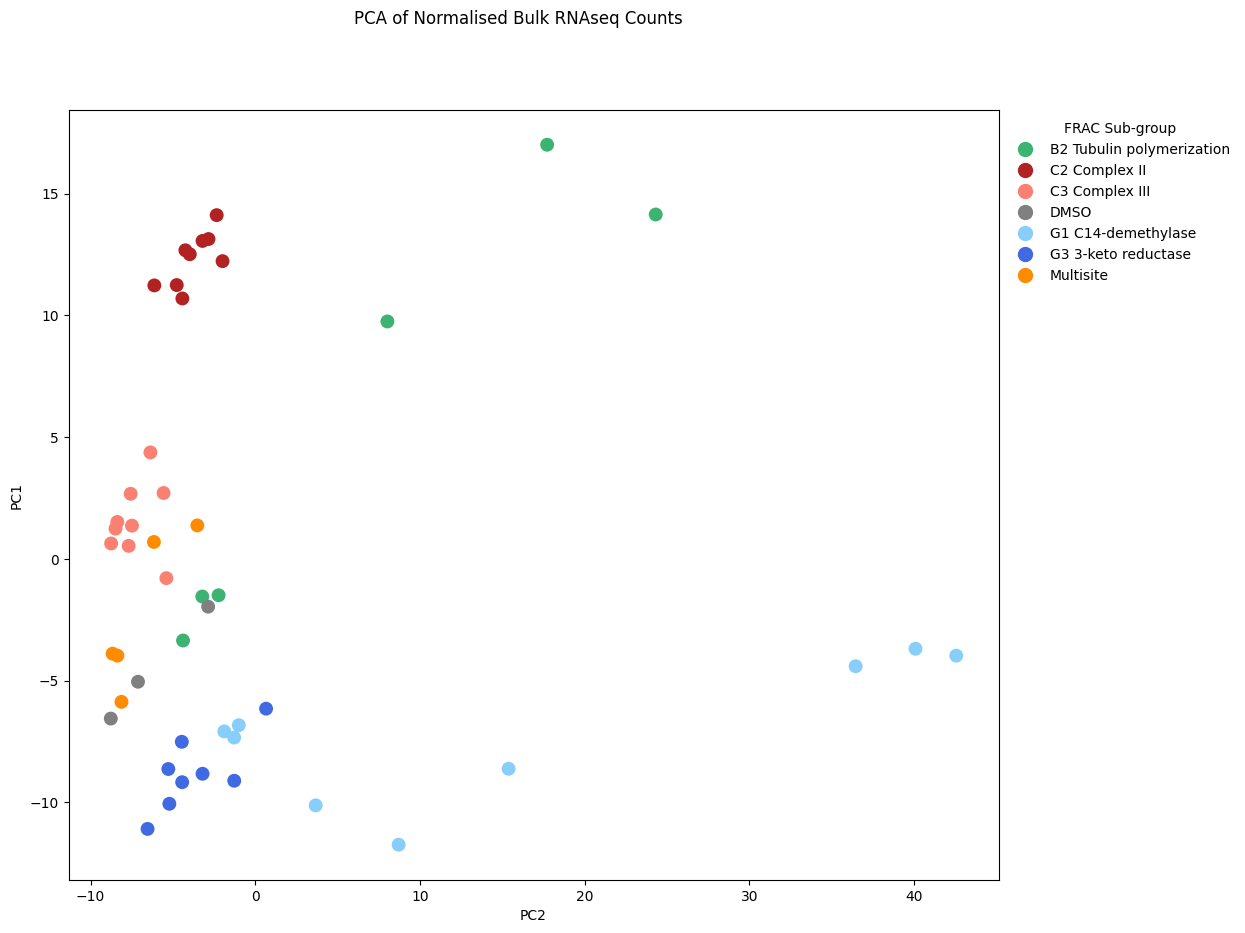

/tmp/ipykernel_12720/2633496962.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(
/tmp/ipykernel_12720/2633496962.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[x] = embedder[:, 0]
/tmp/ipykernel_12720/2633496962.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[y] = embedder[:, 1]


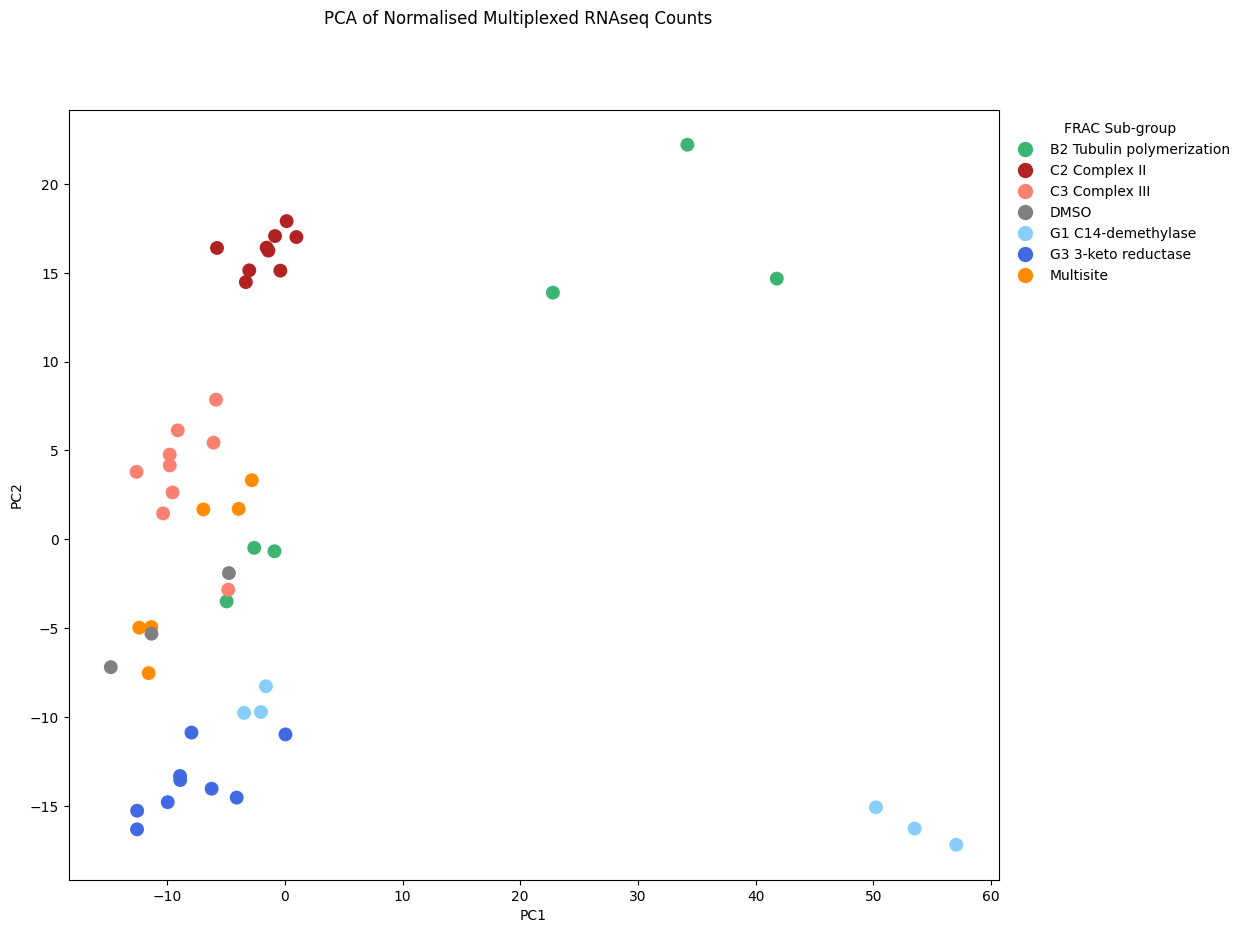

In [116]:
dataset_titles = [
    "Normalised Bulk RNAseq Counts",
    "Normalised Multiplexed RNAseq Counts",
    "Raw Bulk RNAseq Counts",
    "Raw Multiplexed RNAseq Counts",
]
for type_embedding in ["PCA"]:
    for i, dataset in enumerate([df_normalised_alithea, df_normalised_bulk]):
        make_embedding(
            dataset,
            type_embedding,
            f"{type_embedding} of {dataset_titles[i]}",
            treatments_of_interest,
            category_color_map,
        )


In [117]:
df_normalised_alithea = process_dataset("Alithea_Lyon_normalised_deseq.csv", [24])
df_normalised_bulk = process_dataset("Lyon_bulk_normalised_deseq.csv", [24])
# df_raw_alithea = process_dataset("Lyon_alithea_raw.csv", [6, 24])
# df_raw_bulk = process_dataset("Lyon_bulk_raw.csv", [6, 24])
df_normalised_alithea["Metadata_Technology"] = "Multiplexed RNAseq"
df_normalised_bulk["Metadata_Technology"] = "Bulk RNAseq"

common_genes = list(
    set.intersection(
        *list(
            map(lambda x: set(x.columns), [df_normalised_bulk, df_normalised_alithea])
        )
    )
)


# df_raw_alithea["Metadata_Technology"] = "Multiplexed RNAseq"
# df_raw_bulk["Metadata_Technology"] = "Bulk"

df_normalised = pd.concat(
    [df_normalised_alithea[common_genes], df_normalised_bulk[common_genes]], axis=0
)
# common_genes = list(set.intersection(*list(map(lambda x: set(x.columns), [df_raw_alithea, df_raw_alithea]))))
# df_raw = pd.concat([df_raw_alithea[common_genes], df_raw_bulk[common_genes]])

In [118]:
print(df_normalised.shape)
df_normalised = df_normalised[df_normalised["Metadata_Name_Chemical_group"] != ""]
print(df_normalised.shape)

(97, 8641)
(97, 8641)


In [119]:
# print(df_normalised.shape)
# df_normalised = outlier_pca(df_normalised)
# print(df_normalised.shape)

In [120]:
df = df_normalised.copy()
df = df[df["Metadata_Timepoints"].astype(int) == 24]
reference = "DMSO"
mode_of_action_col = "Mode of Action"
technology_col = "Metadata_Technology"
timepoint_col = "Metadata_Timepoints"
concentration_col = "Concentration"
treatment_col = "Treatment"
category_color_map = category_color_map

In [121]:
feature_columns = [col for col in df.columns if col in list(gene_map.keys())]

filtered_expression_df, most_variable_genes = select_most_variable_genes(
    df[feature_columns]
)
feature_columns = most_variable_genes

In [122]:
len(feature_columns)

2157

In [123]:
from scipy.spatial.distance import mahalanobis
from sklearn.preprocessing import StandardScaler

feature_columns = [col for col in df.columns if col in list(gene_map.keys())]
meta_columns = [col for col in df.columns if col not in feature_columns]
df[feature_columns] = df[feature_columns].fillna(0)

variances = df[feature_columns].var().sort_values(ascending=False)
top_columns = (
    variances[variances > 1e-5].head(2000).index.tolist()
)  # Ensure variance is above a threshold
df = df[top_columns + meta_columns]
df[top_columns] = StandardScaler().fit_transform(df[top_columns])
feature_columns = [col for col in df.columns if col in list(gene_map.keys())]

df.rename(
    columns={
        "Metadata_treatments": "Treatment",
        "Metadata_Mode_of_Action": "Mode of Action",
        "Metadata_FRAC_sub_group": "FRAC Sub-group",
        "Metadata_log_concentration": "Log Concentration",
        "Metadata_concentration": "Concentration",
    },
    inplace=True,
)

reference_data_multiplexed = df.loc[
    (df["Treatment"] == "DMSO") & (df["Metadata_Technology"] == "Multiplexed RNAseq"),
    feature_columns,
].copy()
reference_data_bulk = df.loc[
    (df["Treatment"] == "DMSO") & (df["Metadata_Technology"] == "Bulk RNAseq"),
    feature_columns,
].copy()

# Compute the inverse covariance matrix for Mahalanobis distance
cov_matrix_multiplexed = (
    np.cov(reference_data_multiplexed.T)
    + np.eye(reference_data_multiplexed.shape[1]) * 1e-5
)  # Regularization
inv_cov_matrix_multiplexed = np.linalg.inv(cov_matrix_multiplexed)
cov_matrix_bulk = (
    np.cov(reference_data_bulk.T) + np.eye(reference_data_bulk.shape[1]) * 1e-5
)  # Regularization
inv_cov_matrix_bulk = np.linalg.inv(cov_matrix_bulk)

reference_mean_multiplexed = reference_data_multiplexed.mean().to_numpy()
reference_mean_bulk = reference_data_bulk.mean().to_numpy()

threshold_dict = {}

# Compute Mahalanobis distance for each treatment
distances = []
for treatment, group in df.groupby([treatment_col, technology_col]):
    if treatment[0] == reference:
        continue
    for idx, row in group.iterrows():
        if row["Metadata_Technology"] == "Multiplexed RNAseq":
            reference_mean = reference_mean_multiplexed
            inv_cov_matrix = inv_cov_matrix_multiplexed

        elif row["Metadata_Technology"] == "Bulk RNAseq":
            reference_mean = reference_mean_bulk
            inv_cov_matrix = inv_cov_matrix_bulk
        distances.append(
            {
                "Treatment": treatment[0],
                "Technology": treatment[1],
                "Mode of Action": row[mode_of_action_col],
                "FRAC Sub-group": row["FRAC Sub-group"],
                "Timepoint": row[timepoint_col],
                "Concentration": row[concentration_col],
                "Distance": mahalanobis(
                    row[feature_columns].to_numpy(), reference_mean, inv_cov_matrix
                ),
            }
        )


In [124]:
# Create a new DataFrame for visualization
distance_df = pd.DataFrame(distances)

distance_df["Mahanolobis distance normalised by Technology"] = distance_df.groupby(
    "Technology"
)["Distance"].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

# Sort by mode of action, treatment, and technology
distance_df["Treatment_Technology"] = (
    distance_df["Treatment"] + " (" + distance_df["Technology"] + ")"
)
distance_df = distance_df.sort_values(
    by=["FRAC Sub-group", "Treatment", "Technology", "Distance"]
)

In [125]:
treatment2frac = dict(zip(distance_df["Treatment"], distance_df["FRAC Sub-group"]))
treatment2colour = dict(
    [
        (x, category_color_map[treatment2frac[x]])
        for x in distance_df["Treatment"].unique()
    ]
)

In [126]:
distance_df = distance_df[distance_df["Timepoint"].astype(int) == 24]
distance_df["Concentration"] = distance_df["Concentration"].astype(float)

In [127]:
distance_df["Concentration"] = pd.to_numeric(
    distance_df["Concentration"], errors="coerce"
)
# Rename columns for better readability
distance_df.rename(
    columns={
        "Mode of Action": "Mode of Action\n",
        "Distance": "Mahalanobis Distance to DMSO",
        "Mahanolobis distance normalised by Technology": "Mahalanobis Distance to DMSO Normalised by Technology",
    },
    inplace=True,
)

distance_df["Treatment"] = [
    bcs2clearname[x] for x in distance_df["Treatment"].astype(str)
]
new_treatment2colour = {}
for bcs, colour in treatment2colour.items():
    new_treatment2colour[bcs2clearname[bcs]] = colour
    new_treatment2colour[bcs] = colour

treatment2colour = new_treatment2colour

In [128]:
# Step 1: Count unique technologies for each treatment
treatment_technology_counts = distance_df.groupby("Treatment")["Technology"].nunique()

# Step 2: Identify treatments with only one technology
treatments_to_remove = treatment_technology_counts[
    treatment_technology_counts == 1
].index

# Step 3: Filter the original DataFrame to exclude those treatments
distance_df = distance_df[~distance_df["Treatment"].isin(treatments_to_remove)]


In [129]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import mahalanobis


def bootstrap_samples_with_noise(references_array, n_samples, noise_level=1.0):
    """Generate bootstrap samples by drawing randomly from each column of the references and adding noise."""
    n_references, n_features = references_array.shape
    bootstrap_samples = np.zeros((n_samples, n_features))

    # Calculate the mean of the original references
    mean_reference = np.mean(references_array, axis=0)

    # Calculate the noise as the standard deviation of the differences from the mean
    noise = np.std(references_array - mean_reference, axis=0)

    for i in range(n_samples):
        for j in range(n_features):
            bootstrap_samples[i, j] = np.random.choice(
                references_array[:, j]
            ) + np.random.normal(0, noise_level * noise[j])

    return bootstrap_samples


def mahanolobis_threshold_with_bootstrap_and_noise(
    references_df, n_bootstrap_samples=100, regularization=1e-5, noise_level=0
):
    # Assuming you have three DMSO references in a list or array
    # Convert DataFrame to a numpy array for easier manipulation
    references_df = references_df.fillna(0).copy()
    references_array = references_df.to_numpy()

    # Generate bootstrap samples with noise
    # bootstrap_array = bootstrap_samples_with_noise(references_array, n_bootstrap_samples, noise_level)
    bootstrap_array = references_array

    # Initialize a list to store Mahalanobis distances
    mahalanobis_distances = []

    # Perform LOOCV on bootstrap samples
    for index_c in range(bootstrap_array.shape[0]):
        # Get the left-out reference
        ref_c = bootstrap_array[index_c]

        # Get the remaining references
        remaining_indices = list(set(range(bootstrap_array.shape[0])) - {index_c})
        ref_a = bootstrap_array[remaining_indices[0]]
        ref_b = bootstrap_array[remaining_indices[1]]

        # Calculate mean and covariance for the two references
        mean_pair = np.mean([ref_a, ref_b], axis=0)
        cov_pair = np.cov(np.vstack([ref_a, ref_b]).T)

        # Add regularization to the covariance matrix
        cov_pair += np.eye(cov_pair.shape[0]) * regularization
        inv_cov_pair = np.linalg.inv(cov_pair)

        distance = mahalanobis(ref_c, mean_pair, inv_cov_pair)
        mahalanobis_distances.append(distance)

    return mahalanobis_distances


# Example usage (assuming reference_data_multiplexed is your DataFrame)
# distances = mahanolobis_threshold_with_bootstrap_and_noise(reference_data_multiplexed)

# Calculate mean, standard deviation, and threshold
# mean_distance = np.mean(distances)
# std_distance = np.std(distances)
# sem_distance = std_distance / np.sqrt(len(distances))
# threshold = mean_distance + 3 * sem_distance


# Plot histogram of Mahalanobis distances
def plot_histogram(distances):
    plt.hist(distances, bins=30, edgecolor="k", alpha=0.7)
    plt.title("Histogram of Mahalanobis Distances")
    plt.xlabel("Mahalanobis Distance")
    plt.ylabel("Frequency")
    plt.show()


def mahanolobis_with_upsampling(
    subsample_df,
    inv_cov_matrix,
    referece_mean,
    n_bootstrap_samples=100,
    regularization=1e-5,
    noise_level=0,
):
    # Assuming you have three DMSO references in a list or array
    # Convert DataFrame to a numpy array for easier manipulation
    subsample_df = subsample_df.copy()
    subsample_array = subsample_df.to_numpy()
    # Generate bootstrap samples with noise
    bootstrap_array = bootstrap_samples_with_noise(
        subsample_array, n_bootstrap_samples, noise_level
    )
    # Initialize a list to store Mahalanobis distances
    mahalanobis_distances = []

    # Perform LOOCV on bootstrap samples
    for i in range(bootstrap_array.shape[0]):
        # Get the left-out reference
        row = bootstrap_array[i]

        distance = mahalanobis(row, referece_mean, inv_cov_matrix)
        mahalanobis_distances.append(distance)
    return mahalanobis_distances


def bootstrap_difference(
    subsample_df,
    reference_df,
    n_bootstrap_samples=100,
    regularization=1e-5,
    noise_level=0,
    top_n_genes=100,
):
    # Calculate the mean expression of the filtered DataFrames
    expression_sample = subsample_df.mean().to_numpy()
    expression_reference = reference_df.mean().to_numpy()

    # Perform t-test comparing the sample to the reference mean
    u_stat, p_value = stats.mannwhitneyu(expression_sample, expression_reference)

    return p_value
    # Initialize a list


# Example usage (assuming reference_data_multiplexed is your DataFrame)
# distances = mahanolobis_threshold_with_bootstrap_and_noise(reference_data_multiplexed)
# plot_histogram(distances)

# print(f"Mean Mahalanobis Distance: {mean_distance}")
# print(f"Standard Deviation of Mahalanobis Distances: {std_distance}")
# print(f"Threshold (3 times SEM): {threshold}")

In [130]:
distances_mulitplexed = mahanolobis_threshold_with_bootstrap_and_noise(
    reference_data_multiplexed
)
distances_bulk = mahanolobis_threshold_with_bootstrap_and_noise(reference_data_bulk)

In [131]:
reference_data_multiplexed = df.loc[
    (df["Treatment"] == "DMSO") & (df["Metadata_Technology"] == "Multiplexed RNAseq"),
    feature_columns,
].copy()
reference_data_bulk = df.loc[
    (df["Treatment"] == "DMSO") & (df["Metadata_Technology"] == "Bulk RNAseq"),
    feature_columns,
].copy()

In [132]:
# mahanolobis_resampled = {}
# for treatment in df["Treatment"].unique():
#     if treatment == "DMSO":
#         continue
#     expression_bulk = df.loc[(df["Treatment"] == treatment) & (df["Metadata_Technology"] == "Bulk RNAseq"), feature_columns].copy()
#     expression_multiplexed = df.loc[(df["Treatment"] == treatment) & (df["Metadata_Technology"] == "Multiplexed RNAseq"), feature_columns].copy()
#     if expression_bulk.shape[0] == 0 or expression_multiplexed.shape[0] == 0:
#         print(f"Missing data for {treatment}")
#         continue
#     treatment_name = bcs2clearname[treatment]
#     p_bulk = bootstrap_difference(expression_bulk, reference_data_bulk)
#     p_multiplexed = bootstrap_difference(expression_multiplexed, reference_data_multiplexed)
#     mahanolobis_resampled[treatment_name] = {
#         "Multiplexed RNAseq": p_multiplexed,
#         "Bulk RNAseq": p_bulk
# }

In [133]:
distances_mulitplexed_reference = distances_mulitplexed
distances_bulk_reference = distances_bulk

In [134]:
mahanolobis_mean_multiplexed = np.mean(np.array(distances_mulitplexed))
mahanolobis_std_multiplexed = np.std(np.array(distances_mulitplexed))
threshold_multiplexed_mahalanobis = (
    mahanolobis_mean_multiplexed + 2 * mahanolobis_std_multiplexed
)

mahanolobis_mean_bulk = np.mean(np.array(distances_bulk))
mahanolobis_std_bulk = np.std(np.array(distances_bulk))
threshold_bulk_mahalanobis = mahanolobis_mean_bulk + 2 * mahanolobis_std_bulk

/tmp/ipykernel_12720/4124113545.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=15, rotation=0)


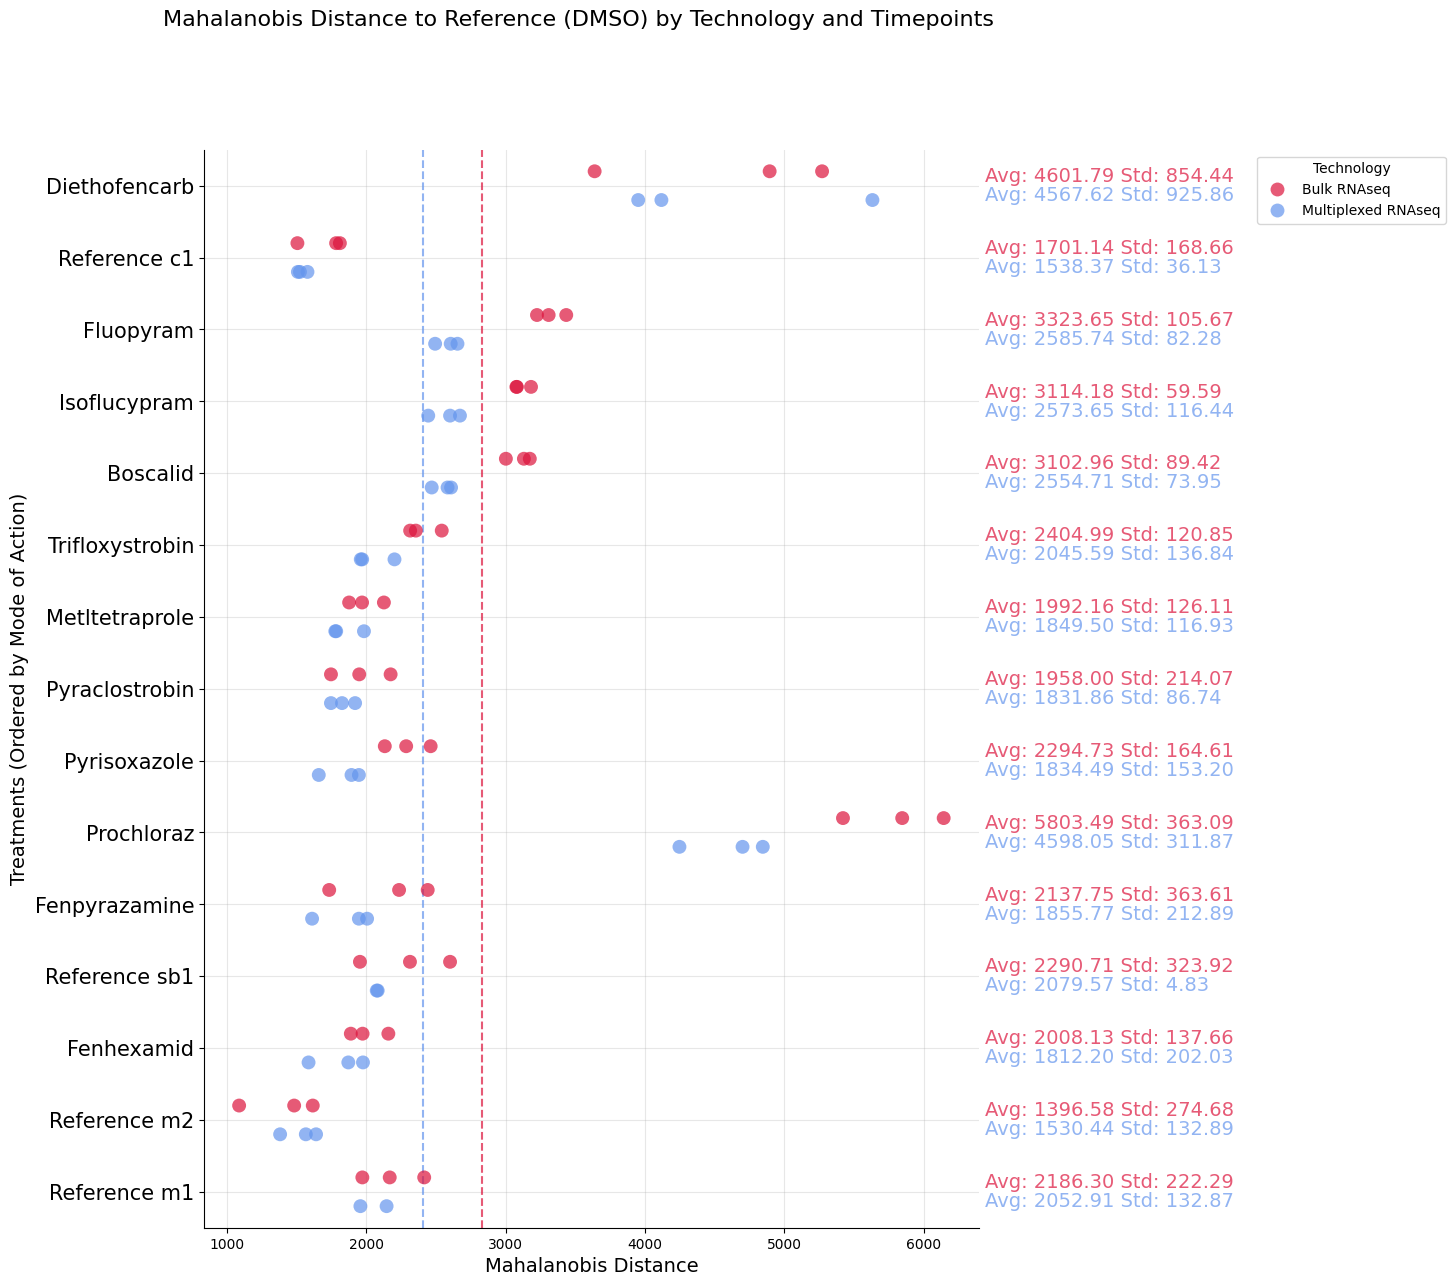

In [135]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Sort the DataFrame by "FRAC Sub-group"
distance_df.sort_values("FRAC Sub-group", ascending=True, inplace=True)

# Define a mapping for timepoints to markers
timepoint_markers = {6: ".", 24: "o"}

# Create a new column for markers based on timepoints
distance_df["Marker"] = distance_df["Timepoint"].map(timepoint_markers)

# Plot the strip plot
fig = plt.figure(figsize=(10, 14))
ax = plt.gca()

sns.stripplot(
    data=distance_df,
    x="Mahalanobis Distance to DMSO",
    y="Treatment",
    hue="Technology",
    dodge=True,
    alpha=0.7,
    s=10,
    jitter=False,
    marker="o",
    ax=ax,
    palette={"Multiplexed RNAseq": "cornflowerblue", "Bulk RNAseq": "crimson"},
)
x_pos = distance_df["Mahalanobis Distance to DMSO"].max() + 300
# Calculate and annotate variance for each treatment and technology
for treatment in distance_df["Treatment"].unique():
    for tech in distance_df["Technology"].unique():
        tech_subset = distance_df[
            (distance_df["Treatment"] == treatment)
            & (distance_df["Technology"] == tech)
        ]
        # bulk_p = mahanolobis_resampled[treatment]["Bulk RNAseq"]
        # multiplexed_p = mahanolobis_resampled[treatment]["Multiplexed RNAseq"]
        # bulk_star = ""
        # multiplexed_star = ""
        # if bulk_p <= 0.05:
        #     bulk_star = "*"
        # if multiplexed_p <= 0.05:
        #     multiplexed_star = "*"

        if not tech_subset.empty:
            variance = tech_subset["Mahalanobis Distance to DMSO"].std()
            mean = tech_subset["Mahalanobis Distance to DMSO"].mean()
            # Calculate the position for annotation
            y_pos = tech_subset["Treatment"].iloc[
                0
            ]  # Use the y position of the treatment
            # x_pos = tech_subset["Mahalanobis Distance to DMSO"].mean()  # Use the mean x position
            if tech == "Multiplexed RNAseq":
                # y_pos += 0.1
                ax.text(
                    x_pos,
                    y_pos,
                    f"Avg: {mean:.2f} Std: {variance:.2f}",
                    fontsize=14,
                    ha="left",
                    va="top",
                    color="cornflowerblue",
                    alpha=0.7,
                )
            else:
                # y_pos -= 0.1
                ax.text(
                    x_pos,
                    y_pos,
                    f"Avg: {mean:.2f} Std: {variance:.2f}",
                    fontsize=14,
                    ha="left",
                    va="bottom",
                    color="crimson",
                    alpha=0.7,
                )

# Customize the plot
ax.axvline(
    x=threshold_multiplexed_mahalanobis,
    color="cornflowerblue",
    linestyle="--",
    alpha=0.7,
)
ax.axvline(x=threshold_bulk_mahalanobis, color="crimson", linestyle="--", alpha=0.7)
ax.spines[["right", "top"]].set_visible(False)
fig.suptitle(
    "Mahalanobis Distance to Reference (DMSO) by Technology and Timepoints", fontsize=16
)
plt.xlabel("Mahalanobis Distance", fontsize=14)
plt.ylabel("Treatments (Ordered by Mode of Action)", fontsize=14)
plt.grid(alpha=0.3)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.35, 1))
ax.set_yticklabels(ax.get_yticklabels(), fontsize=15, rotation=0)

# plt.tight_layout()
plt.savefig("/home/ec2-user/sophia_comparison/figures/mahalanobis_stripplot4.png", bbox_inches="tight", dpi=300)
plt.savefig("/home/ec2-user/sophia_comparison/figures/mahalanobis_stripplot4.svg")
#plt.tight_layout()
#plt.xticks(fontsize=26)
plt.show()

In [136]:
os.system("mv *.png figures/")
os.system("mv *.svg figures/")
os.chdir("./figures/")
os.system("tar -czvf fungi_publication_figures.tar.gz *")

cluster_plot.png
cluster_plot.svg
correlation_matrix_frac.svg
correlation_matrix_moa.svg
correlation_matrix_treatment.svg
fungi_publication_figures.tar.gz
mahalanobis_stripplot4.png
mahalanobis_stripplot4.svg
PCA of Normalised Bulk RNAseq Counts.png
PCA of Normalised Bulk RNAseq Counts.svg
PCA of Normalised Multiplexed RNAseq Counts.png
PCA of Normalised Multiplexed RNAseq Counts.svg
separate_volcano_plot_DiethofencarbBulk_RNAseq.png
separate_volcano_plot_DiethofencarbMultiplexed_RNAseq.png
separate_volcano_plot_IsoflucypramBulk_RNAseq.png
separate_volcano_plot_IsoflucypramMultiplexed_RNAseq.png
separate_volcano_plot_Reference_m1Bulk_RNAseq.png
separate_volcano_plot_Reference_m1Multiplexed_RNAseq.png
separate_volcano_plot_TebuconazoleBulk_RNAseq.png
separate_volcano_plot_TebuconazoleMultiplexed_RNAseq.png
thresholds.png
thresholds.svg
venn_diagrams_grid_with_titles.png
venn_diagrams_grid_with_titles.svg
volcanoes_separate/
volcanoes_separate/separate_volcano_plot_BisoximeterBulk RNAseq

0